# Python アルゴリズム自動売買トレード

--- 
## 演習範囲
* トレード戦略を利用する：取り上げる戦略　（価格の期間平均の差よる戦略、価格の変化量による戦略、価格の方向性による戦略）
 * SMAトレード戦略のバックテストクラス - 202208
 * モメンタムトレード戦略のバックテストクラス - 202208
 * 平均回帰トレード戦略のバックテストクラス  - 202209
 * 他のトレード戦略をクラス化する
   * EMAトレード戦略のバックテストクラス - 202208

* 機械学習を利用する : 機械学習で何を予測するのか ( 価格　/収益/方向性)
 * 線形回帰でのリターン予測 - 202208
 * ロジスティック回帰での方向性予測 - 202209
  * Deeplearningでのマーケットの動き予測 - 202209

* **イベントベースのバックテスト　: 新しいデータを段階的に受け取って処理をする**
 * バックテストのための規定クラス - 202210
   * 証拠金計算追加　⇦ FX自動取引後にリアルタイム処理で作成
   * スワップ計算追加　⇦  FX自動取引後にリアルタイム処理で作成
 * ロングオンリーのバックテストクラス - 202210
 * ロングショートのバックテストクラス - 202210

* **リアルタイムデータとソケット ： 新規生成データでのバックテスト より高速でタイミングよくシグナル生成するためのティックサーバを作る**
 * 簡易ティックサーバの実行 - 202210
   * オイラー方による幾何ブラウン運動
 * 簡易ティックサーバとクライアントと接続 - 202210
 * シグナルをリアルタイムで生成 - 今回
   * モメンタム
   * SMA
   * 平均回帰
 * ストリーミングデータの可視化- 今回
   * リアルタイムレートのみ自動更新
   * 複数のテクニカルも含めて自動更新
   * 複数のシグナルも含めて自動更新

* OWANDA APIでの取引 - 今回
 * 口座情報取得 - 今回
 * レート取得 - 次回以降
 * ヒストリカルデータ取得 - 次回以降
 * 売買 - 次回以降
 * 指値 - 次回以降

---

### 本誌で取り上げているトレード戦略を利用する場合の戦略

* 単純移動平均を利用した戦略
* モメンタムを利用した戦略
* 平均回帰を利用した戦略

機械学習を利用する場合のモデル

* 線形回帰
* ロジスティック回帰
* Deeplearning
---
### 課題・検討　

機械学習で予測する
* ベットサイズ(フィナンシャル機械学習)
* 売買しない(フィナンシャル機械学習)
* CUSUM(フィナンシャル機械学習)

他に利用できる戦略がないか
* EMA
* MACD
* ボリンジャーバンド
* トリプルバリア(フィナンシャル機械学習)

他の機械学習モデルを利用する
* ランダムフォレス
* バギング(フィナンシャル機械学習)
* ブースティング(フィナンシャル機械学習)

データセットの加工
* アウトオブサンプルデータの作成
* 連続データの境界データ削除
* 影響度が高い特徴を抽出

データの入手
* 取引データ、リアルタイムデータの取得

バックテストのためのパラメータ検討
* 売買の方向をロングだけにするか、ショートも可能にするか
* ボラティリティ
* 手数料
* 持高制限
* ポートフォリオ

自動取引構築
* 提供APIの維持 - 9月実施予定

OANDA API 月に50万USDの取引 ＋ 25万円以上の口座残高

60万円 フルレバ 10万USDの取引を３往復すれば維持可能

150円/USD　 * 100000 * 0.04 = 600,000



##  事前準備　ライブラリのインポート
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from datetime import datetime

import requests
import io
import random

Googleドライブをマウントしてライブラリからクラスを呼び出せるようにする

In [ ]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

import os
print("カレントワーキングディレクトリは[" + os.getcwd() + "]です")
_colab_dir = "/content/drive/MyDrive/lib"
os.chdir(_colab_dir)
print("カレントワーキングディレクトリは[" + os.getcwd() + "]です")

Mounted at /content/drive
カレントワーキングディレクトリは[/content]です
カレントワーキングディレクトリは[/content/drive/MyDrive/lib]です


グラフサイズのデフォルト

In [ ]:
figure_size = (22, 8)

## CSVのデータをDataFrameへ格納する処理
--- 
前処理　以下のデータ取得して整形しています　　みずほ銀行　マーケットデータより
参照：https://www.mizuhobank.co.jp/market/quote.csv

###### USDしか拾えないので削除

In [ ]:
def get_close_data():

  # データダウンロード
  url = 'https://www.mizuhobank.co.jp/market/quote.csv'
  res = requests.get(url)
  df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",")

  # データを整形
  df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})
  df_tmp = df_tmp.rename(columns={df_tmp.columns[1]: 'USD'})
  df_tmp = df_tmp.drop(0, axis=0)
  df_tmp = df_tmp.drop(1, axis=0)

  data = pd.DataFrame(df_tmp['USD'].tolist(),columns=['price'], index=pd.to_datetime(df_tmp['Date']).tolist())
  data['price'] = data['price'].astype(np.float64)


  return data

#### def get_close_data を　以下のシンボルを指定して取得できるように修正した
USD	 / GBP / EUR / CAD / CHF / SEK / DKK / NOK / AUD / 	NZD / ZAR / BHD

In [ ]:
def get_close_data(symbol):  
    # データダウンロード
    url = 'https://www.mizuhobank.co.jp/market/quote.csv'
    res = requests.get(url)
    df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",",header=[2])
    
    # データを整形
    df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})
    
    data = pd.DataFrame(df_tmp[symbol].tolist(),columns=['price'], index=pd.to_datetime(df_tmp['Date']).tolist())
    data['price'] = data['price'].astype(np.float64)

    return data.dropna()

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,price
2002-04-01,133.15
2002-04-02,133.20
2002-04-03,133.20
2002-04-04,133.10
2002-04-05,132.30


# トレード戦略を利用する
---
今回取り扱う内容

- SMAトレード戦略のバックテストクラス - 202208
- モメンタムトレード戦略のバックテストクラス - 202208
- 平均回帰トレード戦略のバックテストクラス - 2022/09
- 他のトレード戦略をクラス化する
 - EMAトレード戦略のバックテストクラス - 202208

## 単純移動平均を用いたトレード戦略 
---
2022/08

長期移動平均と短期移動平均を求めて、その値が交差するところ売買シグナルとするテクニカル分析

ゴールデンクロス：　長期の移動平均線を、短期の移動平均線が下から上に突き抜けたとき（交差したとき）　買いサイン

デットクロス：長期の移動平均線を、短期の移動線が上から下に突き抜けたとき（交差したとき）　売りサイン




### 移動平均を求める
rollingの値を変えることで平均を計算する期間（値の数）を変更できる。


In [ ]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()
data.tail()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
 1   SMA1    4806 non-null   float64
 2   SMA2    4596 non-null   float64
dtypes: float64(3)
memory usage: 151.5 KB


SMA　短期とSMA　長期のクロスするところをグラフで確認

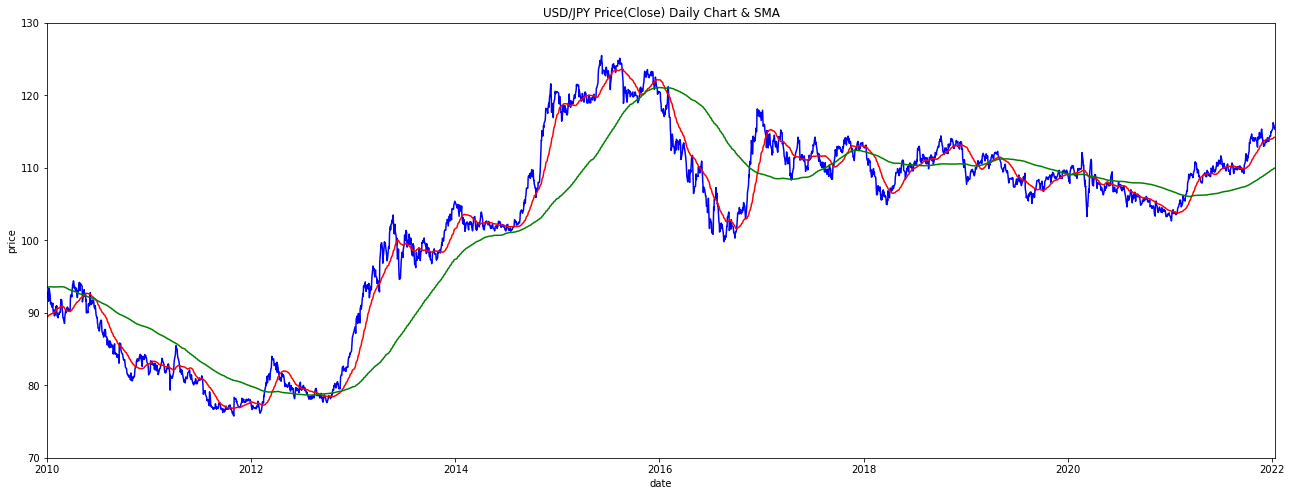

In [ ]:
ymin = 70
ymax = 130
sxmin='2010-01-01'
sxmax=data.index.max().strftime('%Y-%m-%d')
xmin = datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.strptime(sxmax, '%Y-%m-%d')

plt.rcParams["figure.figsize"] = figure_size
plt.plot(data.index, data['price'],color="blue")
plt.plot(data.index, data['SMA1'],color="red")
plt.plot(data.index, data['SMA2'],color="green")

plt.title("USD/JPY Price(Close) Daily Chart & SMA")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

In [ ]:
data['position'] = np.where(data['SMA1'] > data['SMA2'],
                            1, -1)
data['position']

2002-04-01   -1
2002-04-02   -1
2002-04-03   -1
2002-04-04   -1
2002-04-05   -1
             ..
2022-01-04    1
2022-01-05    1
2022-01-06    1
2022-01-07    1
2022-01-11    1
Name: position, Length: 4847, dtype: int64

 SMA戦略を取った場合のポジションの動き
 マイナス


### 2つのSMAベースの戦略に基づくポジションの変化

SMA戦略を取った場合のポジションの動き プラスが買いポジション

SMA戦略を取った場合のポジションの動き マイナスが売りポジション

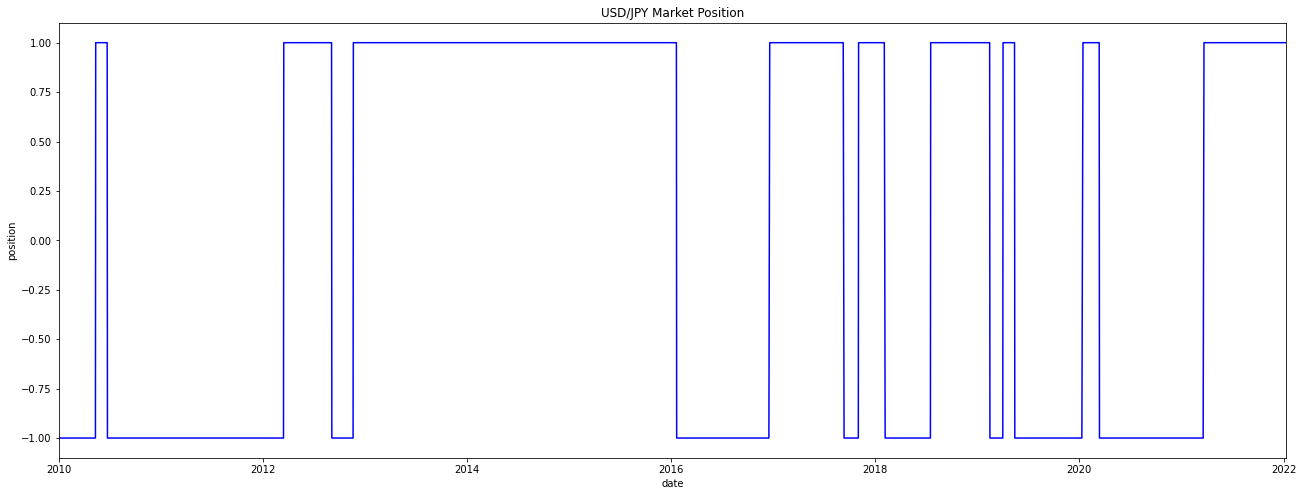

In [ ]:
sxmax=data.index.max().strftime('%Y-%m-%d')
xmin = datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.strptime(sxmax, '%Y-%m-%d')

plt.plot(data.index, data['position'],color="blue")

plt.title("USD/JPY Market Position")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylabel('position')

plt.show()

対数収益率は下落した額と上昇した額を同等の変化率で扱う　
価格の対数収益率を求めている

In [ ]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

### USD/JPYの価格の対数収益率の度数分布

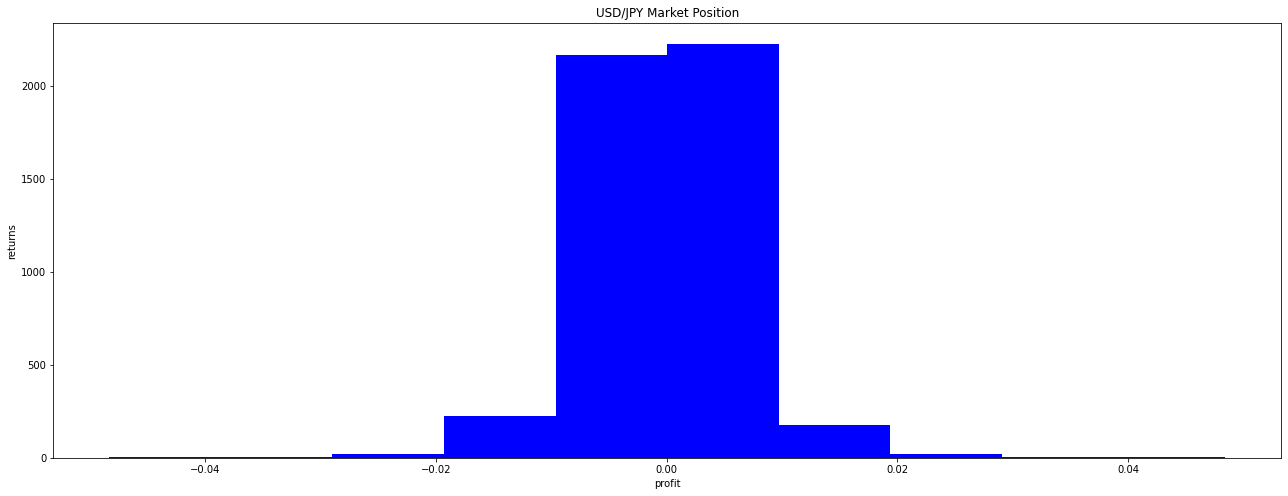

In [ ]:
plt.hist(data['returns'],color="blue")

plt.title("USD/JPY Market Position")
plt.xlabel('profit')
plt.ylabel('returns')

plt.show()

ポジションと対数収益率をかけて戦略の対数収益率を求める

In [ ]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [ ]:
data[['returns', 'strategy']].sum()

returns    -0.143592
strategy    0.311963
dtype: float64

対数収益率の合計に指数関数をかけてグロスパフォーマンスを求める
複利みたいな考え方？

In [ ]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.866241
strategy    1.366104
dtype: float64

### SMAベースの戦略と比較したUSD/JPYのグロスパフォーマンス

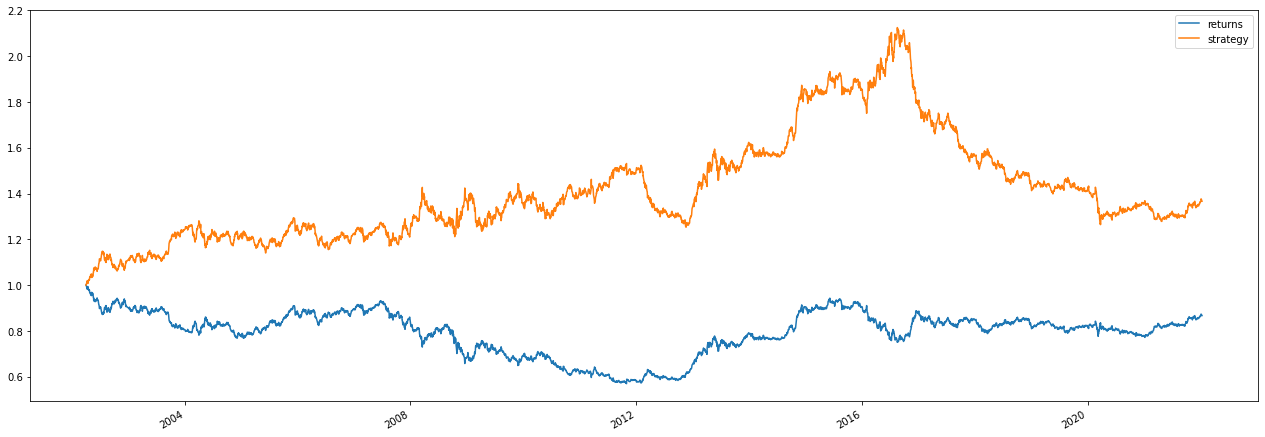

In [ ]:
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=figure_size);

年換算の平均リターン

In [ ]:
data[['returns', 'strategy']].mean() * 252

returns    -0.007467
strategy    0.016223
dtype: float64

In [ ]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.098082
strategy    0.098078
dtype: float64

SMAベースの戦略のグロスパフォーマンス

In [ ]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

累積最大パフォーマンス

In [ ]:
data['cummax'] = data['cumret'].cummax()

### SMAベースの戦略のグロスパフォーマンスと累積最大パフォーマンス

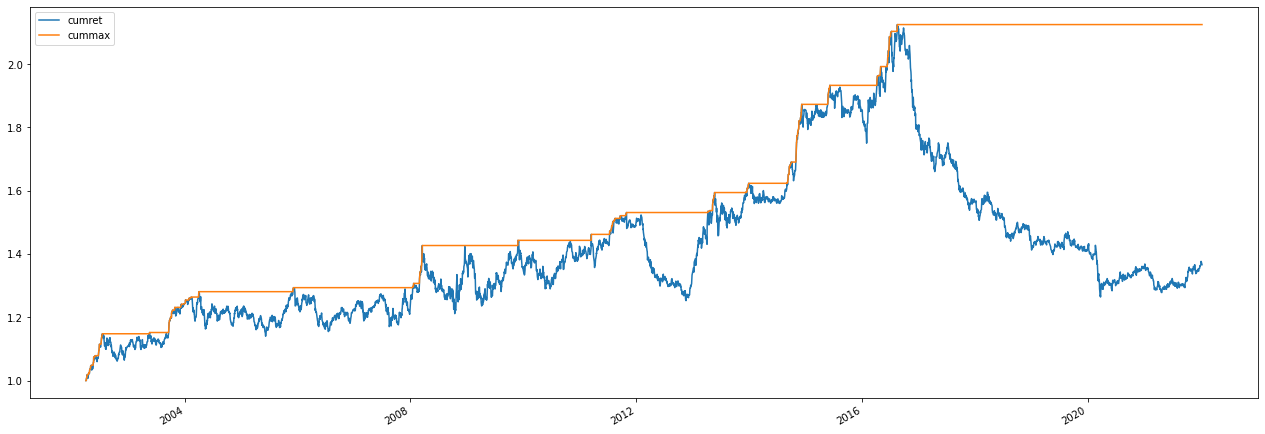

In [ ]:
data[['cumret', 'cummax']].dropna().plot(figsize=figure_size);

In [ ]:
drawdown = data['cummax'] - data['cumret']

In [ ]:
drawdown.max()

0.8612538952003015

In [ ]:
temp = drawdown[drawdown == 0]

In [ ]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [ ]:
periods[12:15]

array([datetime.timedelta(days=2), datetime.timedelta(days=5),
       datetime.timedelta(days=13)], dtype=object)

ポジションを保持する最大日数

In [ ]:
periods.max()

datetime.timedelta(days=772)

###  SMA戦略バックテストクラスのカスタマイズ

上記の内容を本書ではClassにしたが、汎用的ではなかったので、汎用的な形で修正した。

SMAVectorBacktester.py : 投入できるデータセットが　http://hilpisch.com/pyalgo_eikon_eod_data.csv　のデータのみを利用するものになっていた。


MultiDataSMAVectorBacktester.py : データの形式が同じであれば、どんなデータセットでもバックテストできるように修正した。


これにより、いろいろな期間・データの移動平均戦略のバックテストが可能になる


####  SMAの汎用クラスについて

#### MultiDataSMAVectorBacktester

```
==========
Attributes
==========
    symbol: str
        グラフ表示利用する取引銘柄
    dataset: DataFrame [price] index = date
        インデックスがDateでデータにはprice列に価格が格納されたDataframe
    SMA1: int
        短期 SMAの期間
    SMA2: int
        長期 SMAの期間
    start: str
        データセットとして利用するデータの開始日
    end: str
        データセットとして利用するデータの終了日

=======
　Method
=======
    get_data:
        取得したデータセットから SMAとリターン(1つ前の価格の対数収益率)を計算しDataframeに格納する
    set_parameters:
        短期SMAと長期SMAを任意の期間で計算しDataframeに格納する
    run_strategy:
        累積リターンを求める
    plot_results:
        累積リターンを表示する
    update_and_run:
        短期SMAと長期SMAの期間を変更し累積リターンを再度計算する
    optimize_parameters:
        短期SMAと長期SMAの幅とステップを指定し、それらの組み合わせから累積リターンがもっと大きい期間の組み合わせを計算する
```

 SMAの汎用クラスの動作を確認する

In [ ]:
import MultiDataSMAVectorBacktester as MSMA

新規にデータを再取得して、 SMAのトレード戦略を確認する


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB
(0.97, -0.27)
(1.25, 0.11)
(array([ 54., 292.]), 1.24)


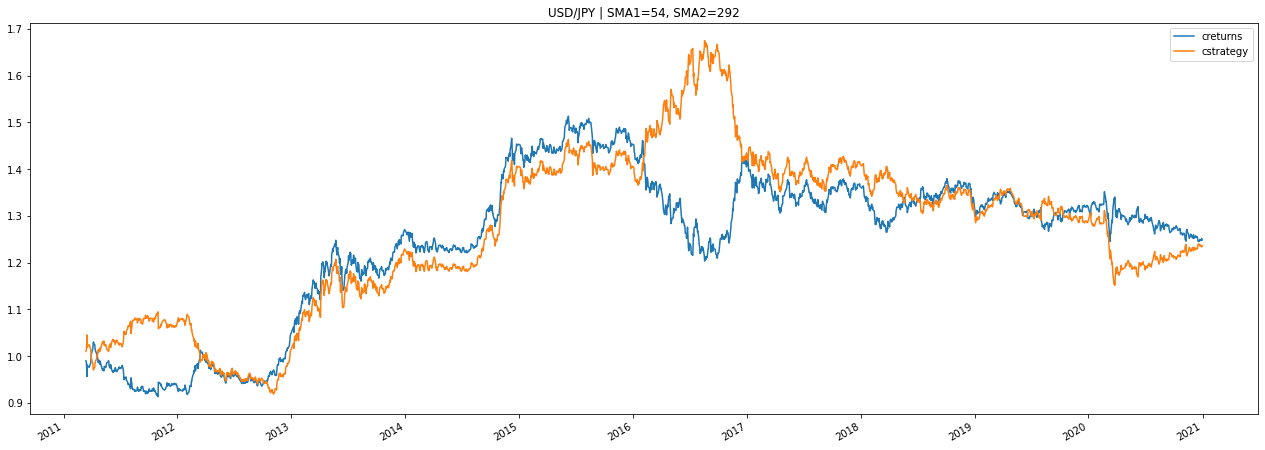

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

smabt = MSMA.MultiDataSMAVectorBacktester('USD/JPY', data, 42, 252,
                                 '2010-01-01', '2020-12-31')
print(smabt.run_strategy())
smabt.set_parameters(SMA1=20, SMA2=100)
print(smabt.run_strategy())

# 収益の高い短期 SMAと長期 SMAの組み合わせを確認する
print(smabt.optimize_parameters((30, 56, 4), (200, 300, 4)))

# 短期 SMA=５4 長期 SMA=292  リターン 124%
smabt.plot_results()

## モメンタムを用いたトレード戦略
---
2022/08

直近の取引のリターンがプラスだったら買い、マイナスだったら売り。
評価するリターンの期間と計算を変更することでカスタマイズできる。


### モメンタム戦略を確認する

直近リターンので、モメンタム戦略を行いパフォーマンスを評価する

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


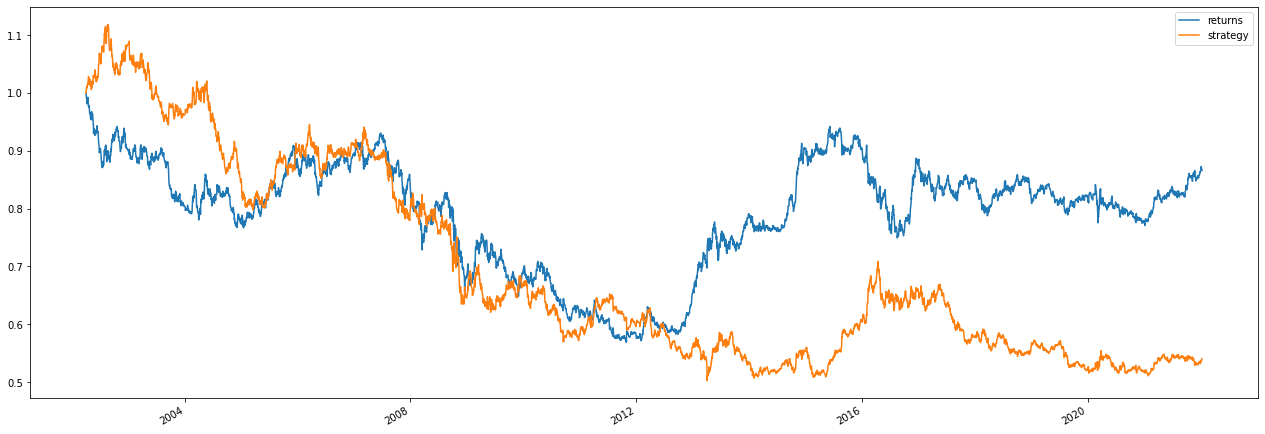

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['position'] = np.sign(data['returns'])
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
            ).apply(np.exp).plot(figsize=figure_size);

### 評価する期間を変更してモメンタム戦略を確認する

直近から2日リターンの平均で、モメンタム戦略を行いパフォーマンスを評価する

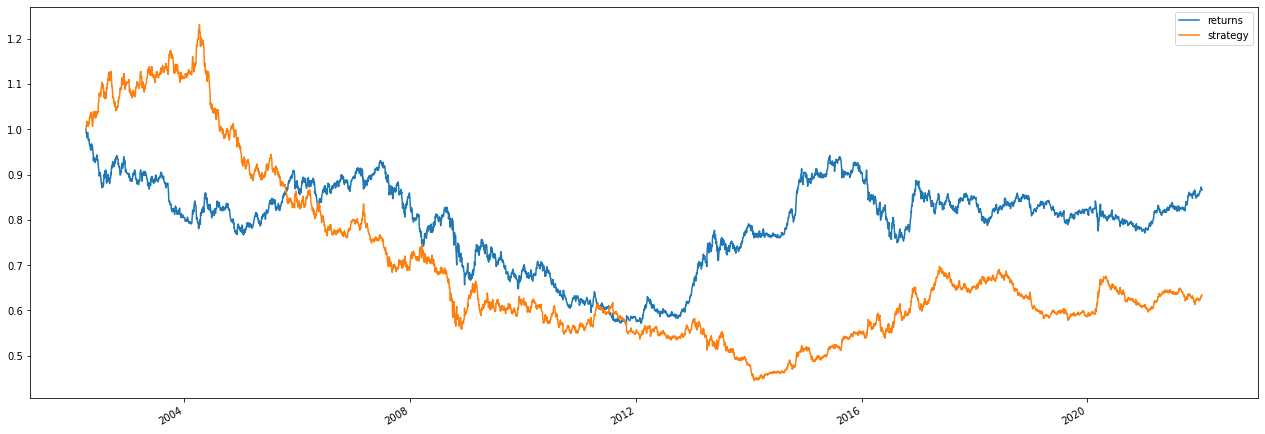

In [ ]:
data['position'] = np.sign(data['returns'].rolling(2).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=figure_size);

直近から3日リターンの平均で、モメンタム戦略を行いパフォーマンスを評価する

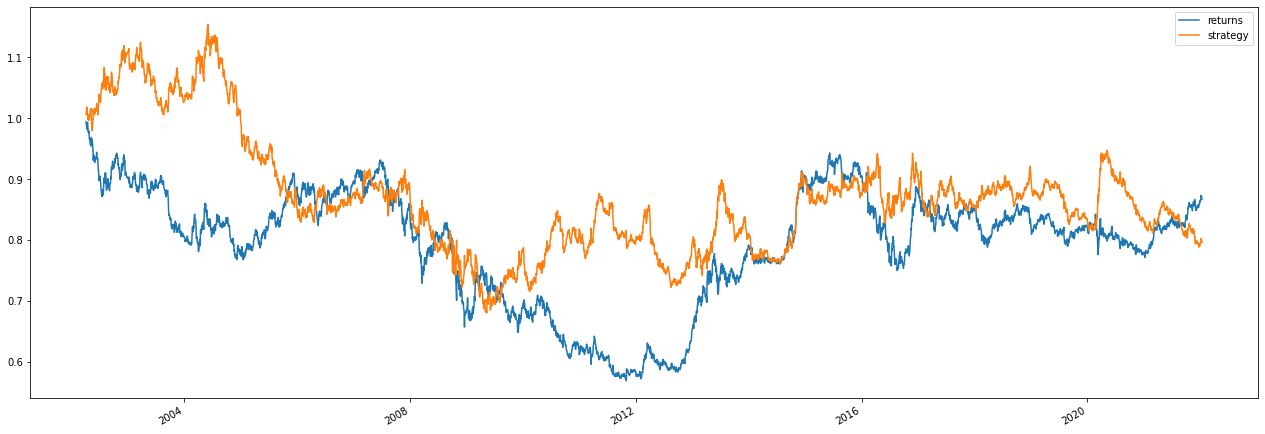

In [ ]:
data['position'] = np.sign(data['returns'].rolling(3).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=figure_size);

直近から4日リターンの平均で、モメンタム戦略を行いパフォーマンスを評価する

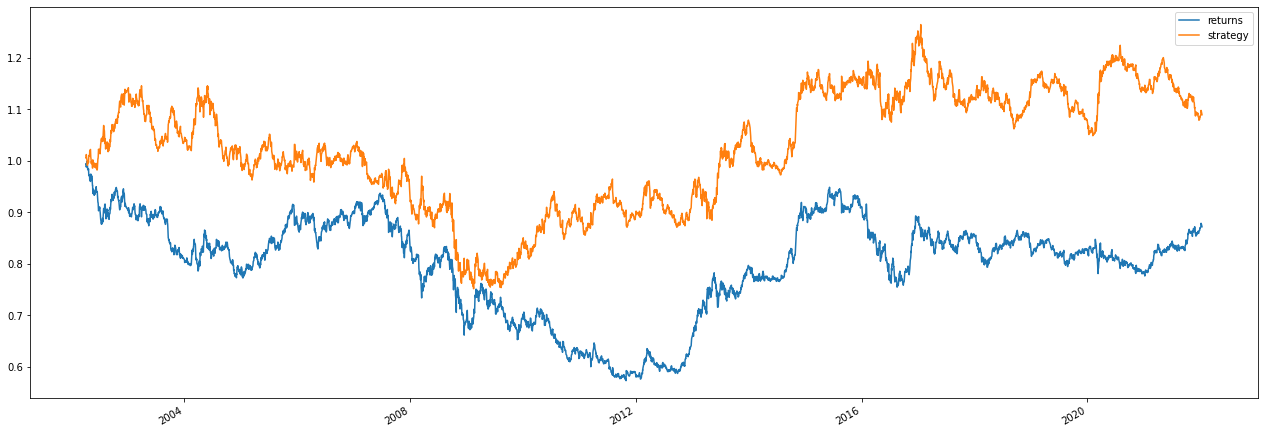

In [ ]:
data['position'] = np.sign(data['returns'].rolling(4).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=figure_size);

*直近から5日リターンの平均で、モメンタム戦略を行いパフォーマンスを評価する*

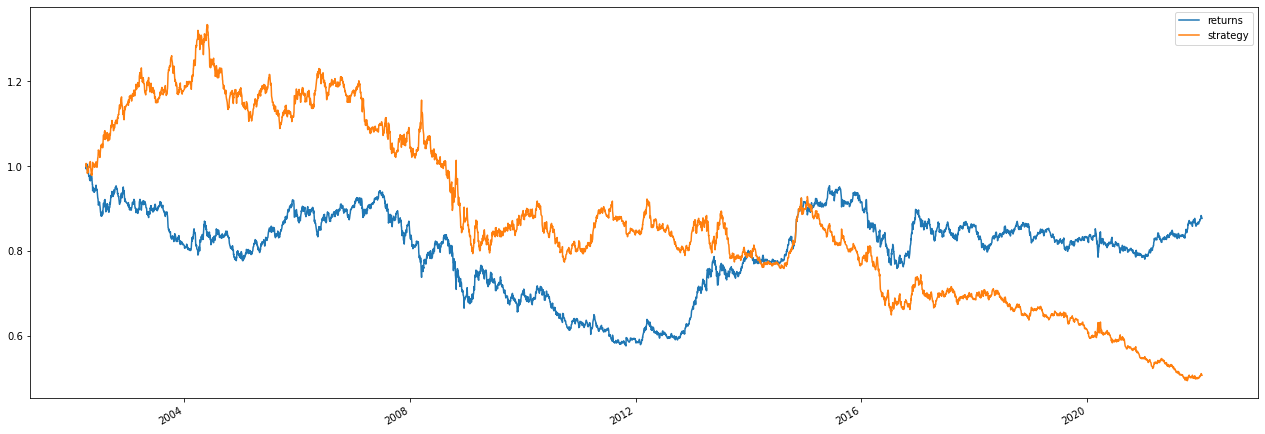

In [ ]:
data['position'] = np.sign(data['returns'].rolling(5).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=figure_size);

### **価格の情報が日単位であるため、評価するタイミングが1回となってしまうので、時間や分単位、もしくはリアルタイムの方が良いかもしれない**

## 7章でリアルタイムデータでシグナル生成を作成する演習あり！

### モメンタム戦略バックテストクラスのカスタマイズ
上記の内容を本書ではClassにしたが、汎用的ではなかったので、汎用的な形で修正した。

MultiLRVectorBacktester.py : 投入できるデータセットが　http://hilpisch.com/pyalgo_eikon_eod_data.csv　のデータのみを利用するものになっていた。

MultiLRVectorBacktester.py : データの形式が同じであれば、どんなデータセットでもバックテストできるように修正した。

これにより、いろいろな期間・データのモメンタム戦略のバックテストが可能になる

In [ ]:
import MultiDataMomVectorBacktester as MMon

モメンタム評価期間直近から３つ

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

mombt = MMon.MultiMomVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31', 10000, 0.0)
mombt.run_strategy(momentum=3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


(10842.95, -1013.11)

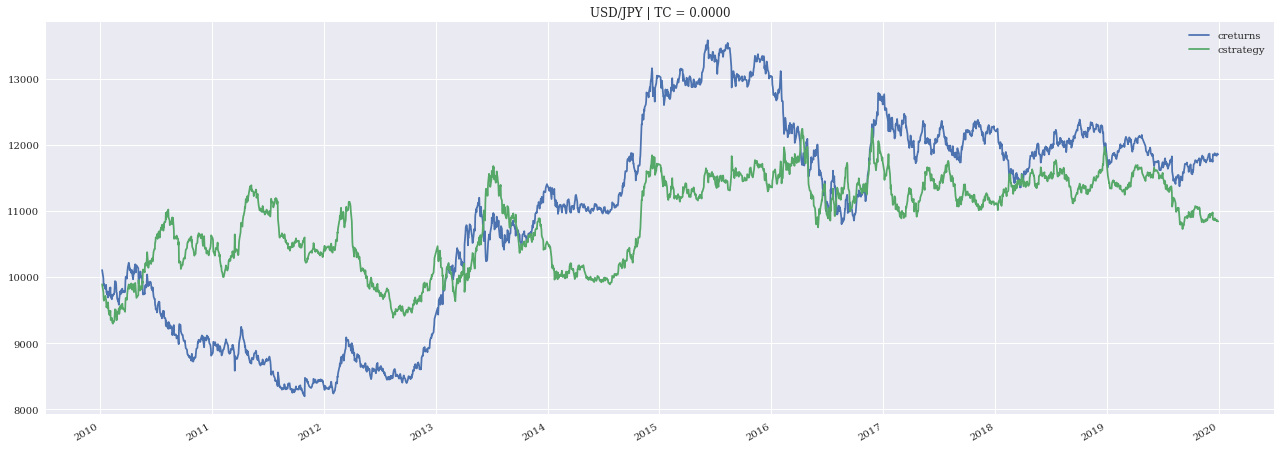

In [ ]:
mombt.plot_results()

モメンタム評価期間直近から４つ

In [ ]:
mombt.run_strategy(momentum=4)

(12806.46, 1077.34)

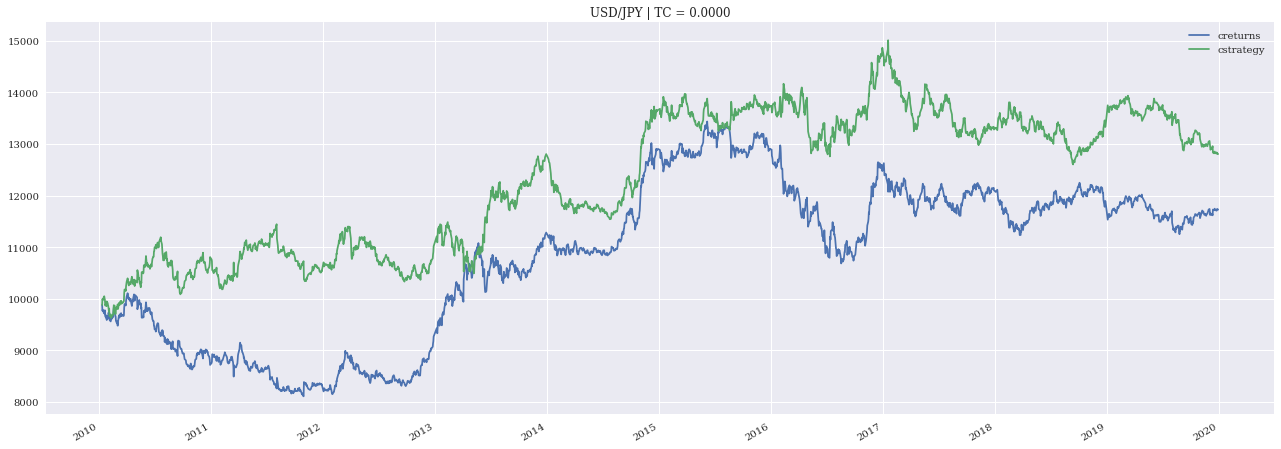

In [ ]:
mombt.plot_results()

モメンタム評価期間直近から５つ

In [ ]:
mombt.run_strategy(momentum=5)

(7018.3, -4850.6)

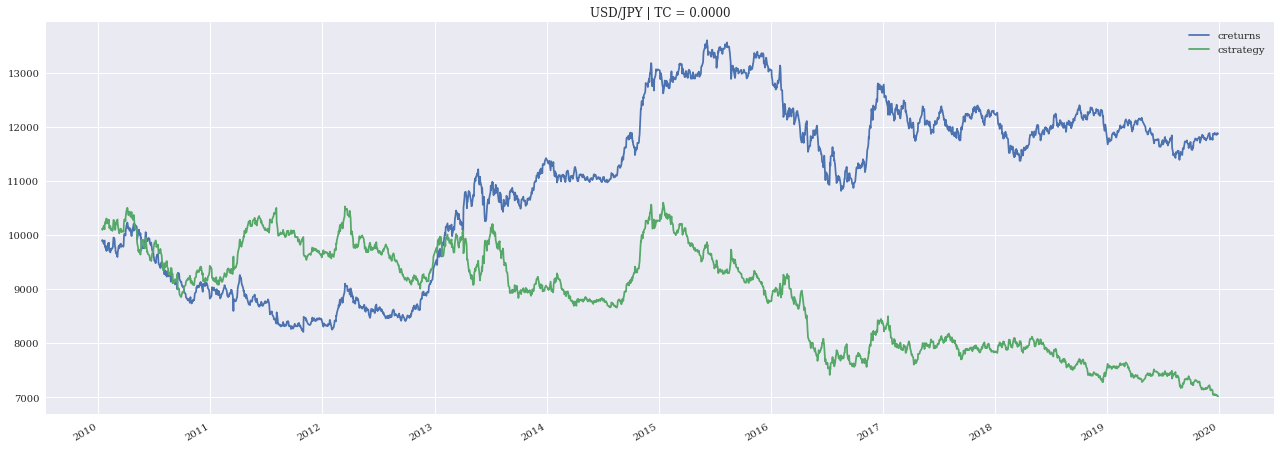

In [ ]:
mombt.plot_results()

## 平均回帰を用いたトレード戦略
---
2022/09

ある金融商品がそのトレンドに対してとても良いパフォーマンスを出した場合は、その金融商品をショートし、その逆もまた然り

現在の価格とSMA（移動平均）との乖離に閾値を設定してロングやショートのシグナルを出す戦略

####  平均回帰のシグナルを求める
おさらい: 移動平均は、rollingの値を変えることで平均を計算する期間（値の数）を変更できる。

例では25日移動平均と価格との差を求めて、乖離が±３.５を超えたらシグナルを出した場合のグラフを表示

In [ ]:
#前日との価格差を対数として表し、それをリターンとした
data['returns'] = np.log(data['price'] / data['price'].shift(1))

# 25 日の移動平均を求める
SMA = 25
# ---------------------------
data['SMA'] = data['price'].rolling(SMA).mean()

# 乖離を判定する閾値を 3.5 とする
threadhold = 3.5
# ---------------------------
data['distance'] = data['price'] - data['SMA']
data.tail()
data.info()

data['distance'].dropna().plot(figsize=figure_size,legend=True)
plt.axhline(threadhold,color="r")
plt.axhline(-threadhold,color="r")
plt.axhline(0,color="b")

#### シグナルベースではなくポジションベースで戦略を確認

閾値を超えた場合は±1を設定し、そうでない場合は nanを設定する

In [ ]:
data['position'] = np.where(data['distance'] > threadhold, -1, np.nan)
data['position'] = np.where(data['distance'] < -threadhold, 1, data['position'])

#postionをキープする場合の処理　符号が変化したら0,符号が継続なら継続している符号を入れる
data['position'] = np.where(data['distance'] * data['distance'].shift(1) < 0, 0, data['position'])
# nan　を０に変更
data['position'] = data['position'].ffill().fillna(0)

data['position'].iloc[SMA:].plot(ylim=[-1.1,1.1],figsize=figure_size)
plt.axhline(0,color="r")

#### 平均回帰の戦略をとった場合とのリターンの差

In [ ]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=figure_size)

#### あんまり良くないので少し閾値変えて確認

28日移動平均と価格との差を求めて、乖離が±2を超えたらシグナルを出した場合のグラフを表示

In [ ]:
# 28 日の移動平均を求める
SMA = 28
data['SMA'] = data['price'].rolling(SMA).mean()
# 乖離を判定する閾値を 2 とする
threadhold = 2
data['distance'] = data['price'] - data['SMA']

data['position'] = np.where(data['distance'] > threadhold, -1, np.nan)
data['position'] = np.where(data['distance'] < -threadhold, 1, data['position'])

#postionをキープする場合の処理　符号が変化したら0,符号が継続なら継続している符号を入れる
data['position'] = np.where(data['distance'] * data['distance'].shift(1) < 0, 0, data['position'])
# nan　を０に変更
data['position'] = data['position'].ffill().fillna(0)

data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=figure_size)

### 平均回帰戦略バックテストクラスのカスタマイズ
上記の内容を本書ではClassにしたが、汎用的ではなかったので、汎用的な形で修正した。

SMAVectorBacktester.py : 投入できるデータセットが　http://hilpisch.com/pyalgo_eikon_eod_data.csv　のデータのみを利用するものになっていた。

MultiDataMRVectorBacktester.py : データの形式が同じであれば、どんなデータセットでもバックテストできるように修正した。

これにより、いろいろな期間・データの平均戦略のバックテストが可能になる

平均回帰の汎用クラスについて
MultiDataMRVectorBacktester

```
==========
Attributes
==========
    symbol: str
        グラフ表示利用する取引銘柄
    dataset: DataFrame [price] index = date
        インデックスがDateでデータにはprice列に価格が格納されたDataframe
    SMA: int
        SMAの期間
    threadhold: float
        乖離を判定する閾値
    start: str
        データセットとして利用するデータの開始日
    end: str
        データセットとして利用するデータの終了日
    amount: int
        取引数りょう
    tc: float
        取引コスト %

=======
　Method
=======
    get_data:
        取得したデータセットから SMAとリターン(1つ前の価格の対数収益率)を計算しDataframeに格納する
    run_strategy:
        累積リターンを求める
    plot_results:
        累積リターンを表示する
```

In [ ]:
import MultiDataMRVectorBacktester as MMR

SMA16日でシグナル発生閾値2の場合のリターン

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

mrbt = MMR.MultiDataMRVectorBacktester('USD/JPY', data, '2010-01-01', '2020-12-31', 10000, 0.001)

print(mrbt.run_strategy(SMA=16, threshold=2))
mrbt.plot_results()

SMA２８日でシグナル発生閾値２.5の場合のリターン

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

mrbt = MMR.MultiDataMRVectorBacktester('USD/JPY', data, '2010-01-01', '2020-12-31', 10000, 0.001)

print(mrbt.run_strategy(SMA=28, threshold=2.5))
mrbt.plot_results()

SMA42日でシグナル発生閾値2.5の場合のリターン

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

mrbt = MMR.MultiDataMRVectorBacktester('USD/JPY', data, '2010-01-01', '2020-12-31', 10000, 0.001)

print(mrbt.run_strategy(SMA=42, threshold=2.5))
mrbt.plot_results()

## 他のトレード戦略をクラス化する 
---
2022/08
- EMAを用いたトレード戦略

### 指数平滑移動平均（EMA)を用いたトレード戦略 
---
指数平滑移動平均線（EMA）とは、トレンドを早く知るためのテクニカル指標です。単純移動平均線（SMA）と比べて、より早く値動きに反応することが特徴です。

 EMAをSMA同様にクラス化します

####  EMAの汎用クラスについて

#### MultiData EMAVectorBacktester

```
==========
Attributes
==========
    symbol: str
        グラフ表示利用する取引銘柄
    dataset: DataFrame [price] index = date
        インデックスがDateでデータにはprice列に価格が格納されたDataframe
    SMA1: int
        短期 EMAの期間
    SMA2: int
        長期 EMAの期間
    start: str
        データセットとして利用するデータの開始日
    end: str
        データセットとして利用するデータの終了日

=======
　Method
=======
    get_data:
        取得したデータセットから EMAとリターン(1つ前の価格の対数収益率)を計算しDataframeに格納する
    set_parameters:
        短期EMAと長期EMAを任意の期間で計算しDataframeに格納する
    run_strategy:
        累積リターンを求める
    plot_results:
        累積リターンを表示する
    update_and_run:
        短期EMAと長期EMAの期間を変更し累積リターンを再度計算する
    optimize_parameters:
        短期EMAと長期EMAの幅とステップを指定し、それらの組み合わせから累積リターンがもっと大きい期間の組み合わせを計算する
```

In [ ]:
import MultiDataEMAVectorBacktester as MEMA

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

smabt = MEMA.MultiDataEMAVectorBacktester('USD/JPY', data, 42, 250,
                                 '2010-01-01', '2020-12-31')
print(smabt.run_strategy())
smabt.set_parameters(EMA1=20, EMA2=100)
print(smabt.run_strategy())

# 収益の高い短期 EMAと長期EMAの組み合わせを確認する
print(smabt.optimize_parameters((10, 80, 2), (150, 300, 2)))

# 短期EMA=５4 長期EMA=292  リターン 124%
smabt.plot_results()

# 機械学習を利用する
---

今回取り扱う内容
*   線形回帰で指数の水準や値動きの方向を予測する - 2022/08
*   **ロジスティック回帰で分類問題を予測する - 2022/09**
*   **ニューラルネットワークでマーケットの動きを予測する - 2022/09**

## 線形回帰での予測
---
2022/08

指数の水準や値動きの方向を予測する



### ランダムな値で線形回帰を確認

In [ ]:
from pylab import mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

In [ ]:
x = np.linspace(0, 10)

In [ ]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
set_seeds() # <4>

In [ ]:
y = x + np.random.standard_normal(len(x))
reg = np.polyfit(x, y, deg=1)
reg

array([0.94612934, 0.22855261])

ランダムな値に対して回帰線を引く

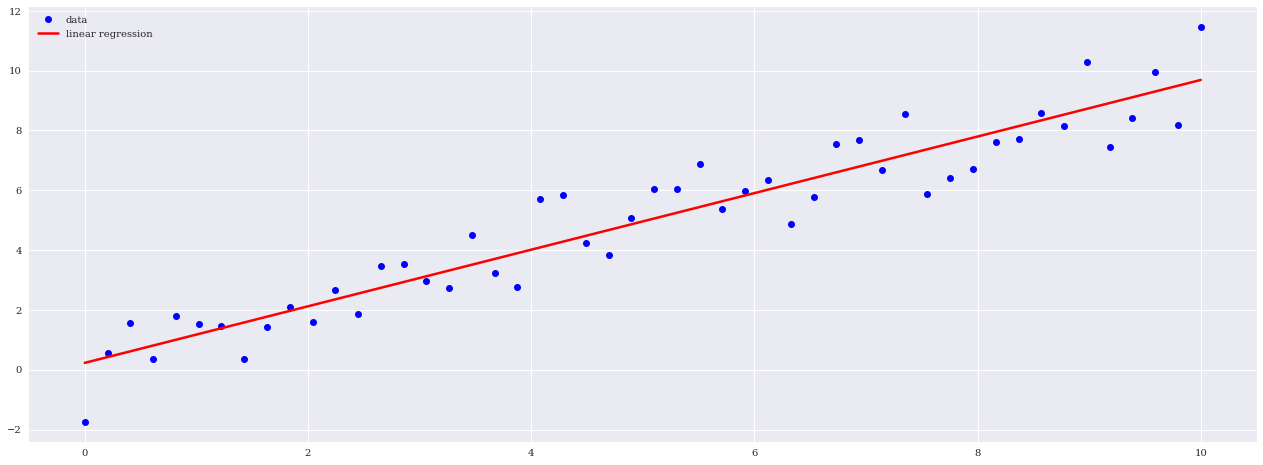

In [ ]:
plt.figure(figsize=figure_size)
plt.plot(x, y, 'bo', label='data')
plt.plot(x, np.polyval(reg, x), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);

要素数を増やして回帰線を伸ばす

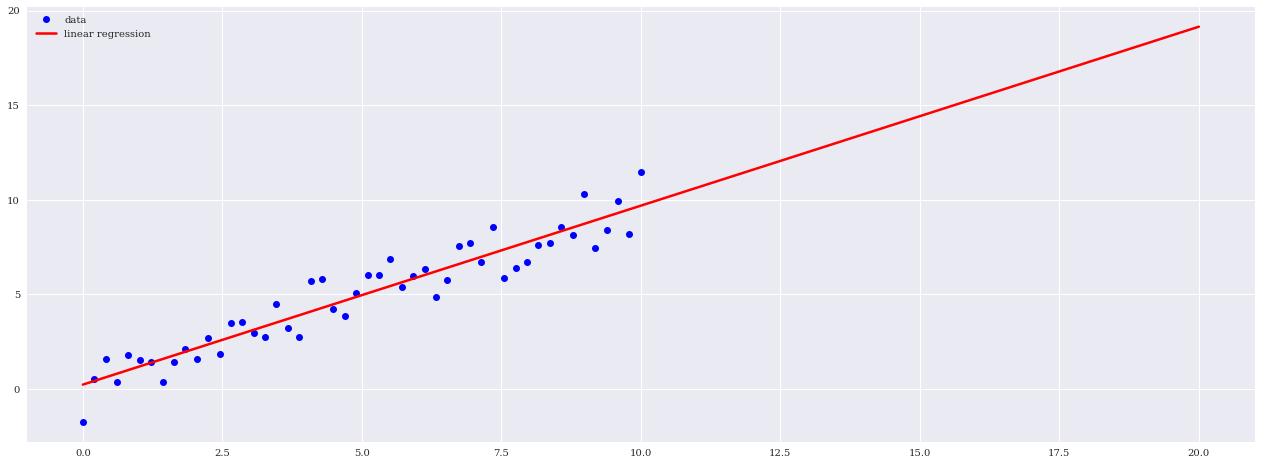

In [ ]:
plt.figure(figsize=figure_size)
plt.plot(x, y, 'bo', label='data')
xn = np.linspace(0, 20)
plt.plot(xn, np.polyval(reg, xn), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);

### 価格予測の基本的な考え方

時系列データの予測は、1つの特別な特徴量を扱う必要がある。データを時系列で順序付けるコト。線形回帰は、順序性は重要ではない。時系列予測においては、順序性が重要で過去3日分のデータから次の日の価格を予測するということを繰り返します。

In [ ]:
x = np.arange(12)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
lags = 3
m = np.zeros((lags + 1, len(x) - lags))
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]
    
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [ ]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [ ]:
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

線形予測に利用するデータの数を5個に設定している

In [ ]:
lags = 5
data = get_close_data('USD')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,price
2002-04-01,133.15
2002-04-02,133.20
2002-04-03,133.20
2002-04-04,133.10
2002-04-05,132.30


In [ ]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag) # <1>
    cols.append(col)
data.dropna(inplace=True)

In [ ]:
data[col]

2002-04-08    133.15
2002-04-09    133.20
2002-04-10    133.20
2002-04-11    133.10
2002-04-12    132.30
               ...  
2022-01-04    114.41
2022-01-05    114.40
2022-01-06    114.97
2022-01-07    114.89
2022-01-11    115.02
Name: lag_5, Length: 4842, dtype: float64

In [ ]:
reg = np.linalg.lstsq(data[cols], data['price'],
                      rcond=None)[0]

reg

array([ 0.9621788 ,  0.01443261,  0.04796622, -0.03261574,  0.00798039])

線形回帰の予測結果を格納

In [ ]:
data['prediction'] = np.dot(data[cols], reg)

回帰分析で予測した結果を表示

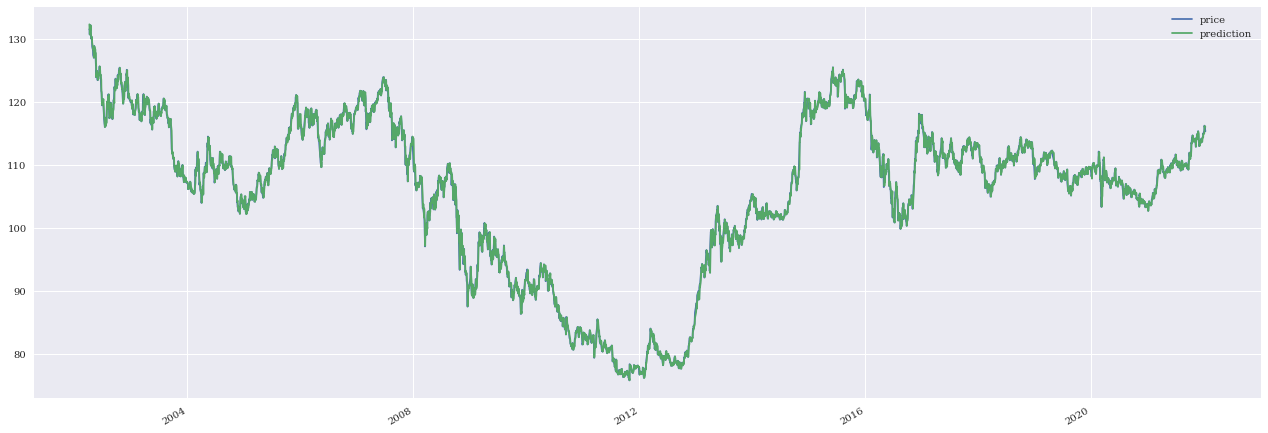

In [ ]:
data[['price', 'prediction']].plot(figsize=figure_size);

予測結果を拡大表示して確認

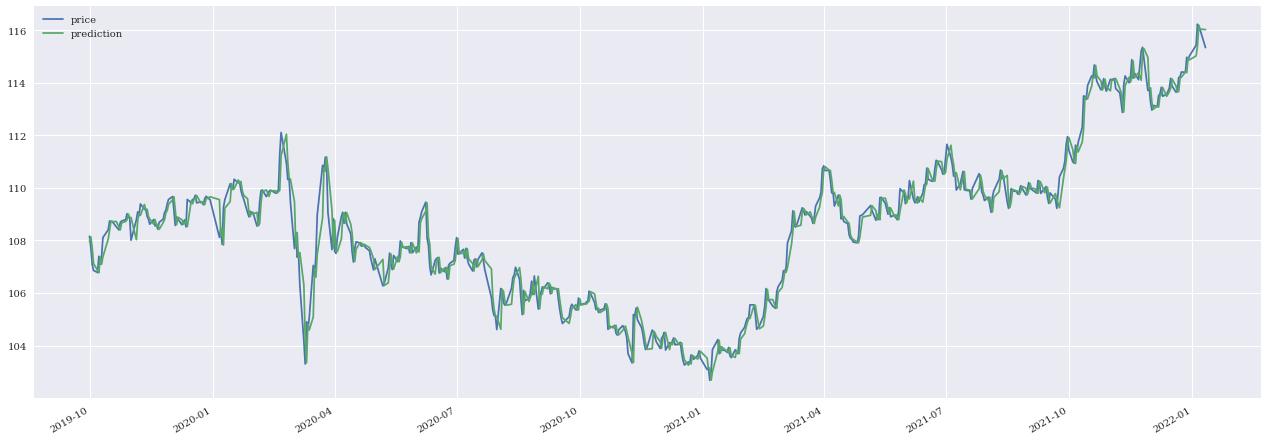

In [ ]:
data[['price', 'prediction']].loc['2019-10-1':].plot(figsize=figure_size);

予測した価格にてリターンを予測する

In [ ]:
lags = 5

data['return'] = np.log(data['price'] /
                         data['price'].shift(1))

data.dropna(inplace=True)

cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <3>
    cols.append(col)
data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['return'],
                      rcond=None)[0]

reg

array([-0.04095893, -0.02476086,  0.02179523, -0.00786381, -0.03198374])

線形回帰の予測結果を格納

In [ ]:
data['prediction'] = np.dot(data[cols], reg)

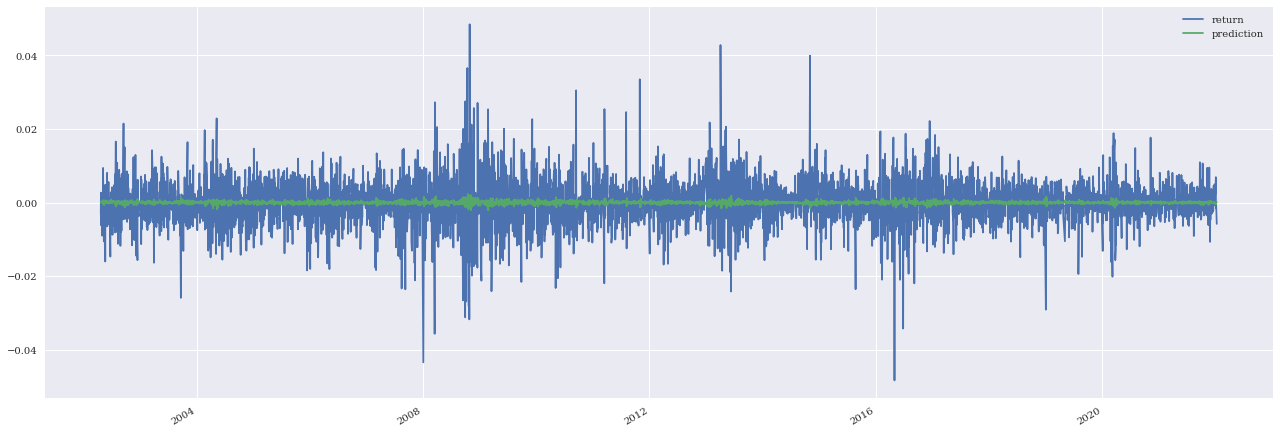

In [ ]:
data[['return', 'prediction']].iloc[lags:].plot(figsize=figure_size);

In [ ]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()
hits

 1.0    2457
-1.0    2329
 0.0      50
dtype: int64

In [ ]:
hits.values[0] / sum(hits)

0.5080645161290323

In [ ]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']),
                      rcond=None)[0]
reg

array([-5.8867772 , -3.89203983,  2.57166665,  0.21872538, -2.84382374])

In [ ]:
data['prediction'] = np.sign(np.dot(data[cols], reg))

In [ ]:
data['prediction'].value_counts()

-1.0    2452
 1.0    2384
Name: prediction, dtype: int64

In [ ]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

hits

 1.0    2467
-1.0    2319
 0.0      50
dtype: int64

In [ ]:
hits.values[0] / sum(hits)

0.510132340777502

In [ ]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
2002-04-16,131.85,0.004929,0.003427,0.003056,-0.006482,0.000000,-1.0,-0.002651
2002-04-17,130.95,-0.002651,0.004929,0.003427,0.003056,-0.006482,1.0,-0.006849
2002-04-18,130.60,-0.006849,-0.002651,0.004929,0.003427,0.003056,1.0,-0.002676
2002-04-19,130.10,-0.002676,-0.006849,-0.002651,0.004929,0.003427,1.0,-0.003836
2002-04-22,130.30,-0.003836,-0.002676,-0.006849,-0.002651,0.004929,1.0,0.001536


In [ ]:
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)

return      0.872466
strategy    2.649168
dtype: float64

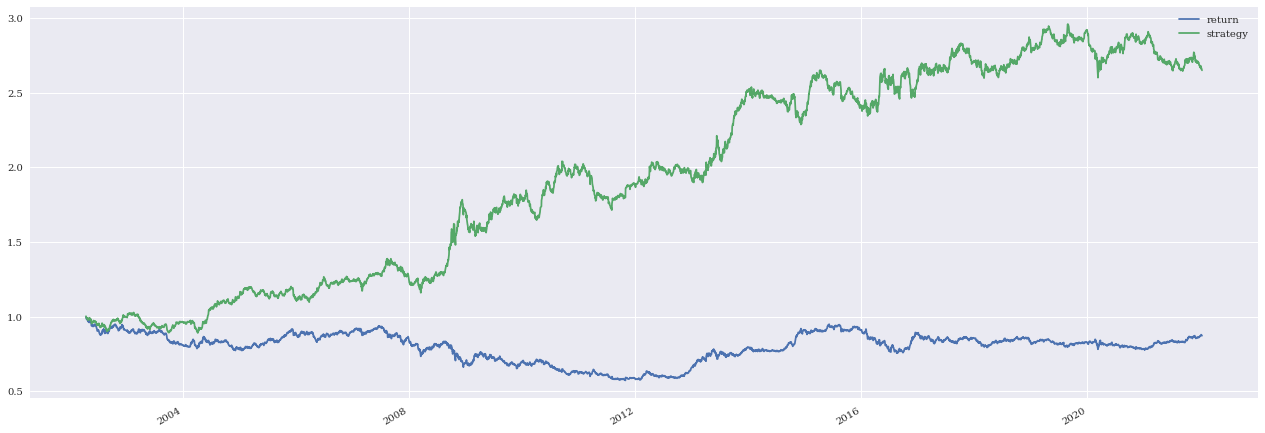

In [ ]:
data[['return', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=figure_size);

### 線形回帰での予測バックテストクラスのカスタマイズ

上記の内容を本書ではClassにしたが、汎用的ではなかったので、汎用的な形で修正した。

MultiLRVectorBacktester.py : 投入できるデータセットが　http://hilpisch.com/pyalgo_eikon_eod_data.csv　のデータのみを利用するものになっていた。


MultiLRVectorBacktester.py : データの形式が同じであれば、どんなデータセットでもバックテストできるように修正した。


これにより、いろいろな期間・データの線形回帰による価格予測戦略のバックテストが可能になる

In [ ]:
import MultiDataLRVectorBacktester as MLR

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

lrbt = MLR.MultiDataLRVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31',
                                     10000, 0.0)

lrbt.run_strategy('2010-01-01', '2019-12-31',
                  '2010-01-01', '2019-12-31', lags=5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


(21514.01, 9645.11)

In [ ]:
lrbt.run_strategy('2010-01-01', '2017-12-31',
                  '2018-01-01', '2019-12-31', lags=5)

(11388.63, 1565.28)

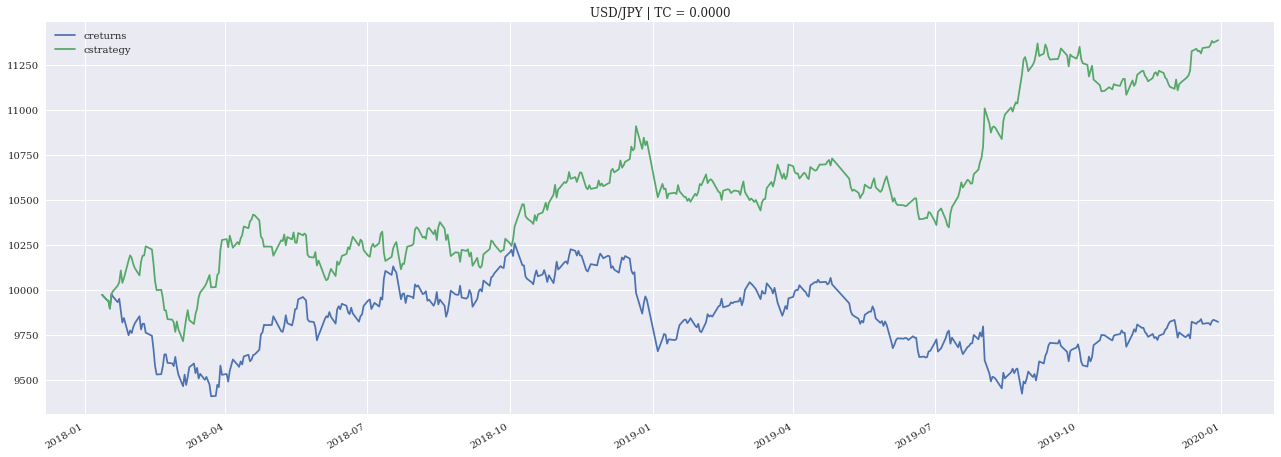

In [ ]:
lrbt.plot_results()

## ロジスティック回帰での予測
---

2022/09

ロジスティック回帰：いくつかの要因（説明変数）から「2値の結果（目的変数）」が起こる確率を説明・予測することができる統計手法

マーケットの方向性（上がる・下がる）　を予測する

### ロジスティック回帰のおさらい

例として、学習時間に対するテストの合格・不合格の予測をロジスティック回帰で確認する

In [ ]:
from sklearn import linear_model

学習データ

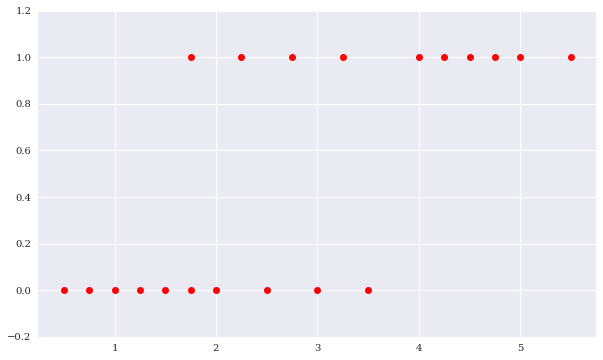

In [ ]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1])

plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.ylim(-0.2, 1.2);

線形回帰を適用すると直線が引かれるだけでうまく予測ができない

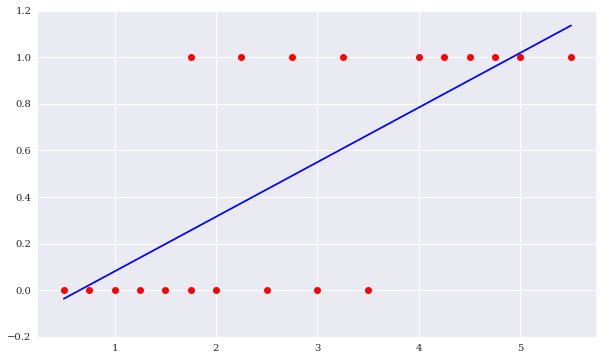

In [ ]:
reg = np.polyfit(hours, success, deg=1)

plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, np.polyval(reg, hours), 'b')
plt.ylim(-0.2, 1.2);

ロジスティック回帰で合格・不合格を予測する

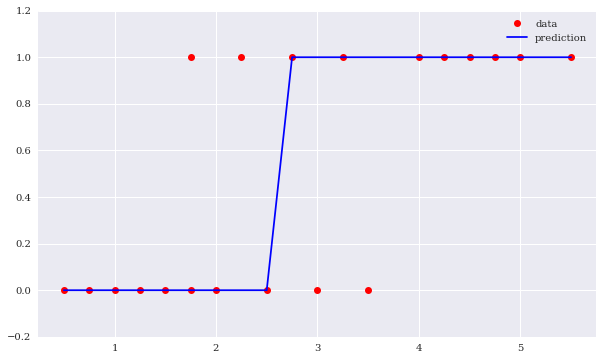

In [ ]:
lm = linear_model.LogisticRegression(solver='lbfgs')

hrs = hours.reshape(1, -1).T

lm.fit(hrs, success)

prediction = lm.predict(hrs)

plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.legend(loc=0)
plt.ylim(-0.2, 1.2);

単純に時間が一定量より大きいからと言って合格する訳ではない
そこで、学習時間に対する合格確率・不合格確率を求める

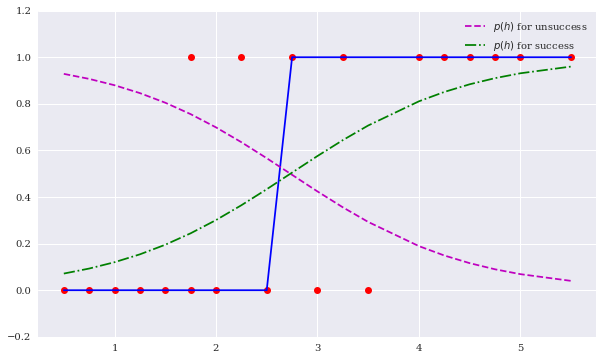

In [ ]:
prob = lm.predict_proba(hrs)

plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, prediction, 'b')
plt.plot(hours, prob.T[0], 'm--',
         label='$p(h)$ for unsuccess')
plt.plot(hours, prob.T[1], 'g-.',
         label='$p(h)$ for success')
plt.ylim(-0.2, 1.2)
plt.legend(loc=0);

### ロジスティック回帰でのマーケット方向性予測

マーケット情報のデータ前処理を実施

過去のリターン（価格差）をラグとして複数の値をベクトル化し、特徴量として学習データとしている

lags=3　は過去3回分のリターンを１行のデータとして集め、その結果直近のリターンが得られたという形で学習する。

予測結果はリターン値の

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

#前日との価格差を対数として表し、それをリターンとした
data['returns'] = np.log(data['price'] / data['price'].shift(1))

data.dropna(inplace=True)

#
lags = 3

cols = []
for lag in range(1, lags + 1) :
   col = 'lag_{}'.format(lag)
   data[col] = data['returns'].shift(lag)
   cols.append(col)

data.dropna(inplace=True)
data[cols]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,lag_1,lag_2,lag_3
2002-04-05,-0.000751,0.000000,0.000375
2002-04-08,-0.006029,-0.000751,0.000000
2002-04-09,-0.005685,-0.006029,-0.000751
2002-04-10,0.000000,-0.005685,-0.006029
2002-04-11,-0.006482,0.000000,-0.005685
...,...,...,...
2022-01-04,0.001131,-0.000696,0.004970
2022-01-05,0.003558,0.001131,-0.000696
2022-01-06,0.006907,0.003558,0.001131
2022-01-07,-0.001550,0.006907,0.003558


ヒット率を求めるためにimport

In [ ]:
from sklearn.metrics import accuracy_score

ロジスティック回帰で予測

In [ ]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

lm.fit(data[cols], np.sign(data['returns']))

data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()

 1.0    3050
-1.0    1793
Name: prediction, dtype: int64

正しい予測と間違った予測の数

In [ ]:
hits = np.sign(data['returns'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

hits

 1.0    2452
-1.0    2338
 0.0      50
dtype: int64

予測のヒット率

In [ ]:
accuracy_score(data['prediction'],
               np.sign(data['returns']))

0.5062977493289283

予測した結果をもとに取引した場合のリターン結果

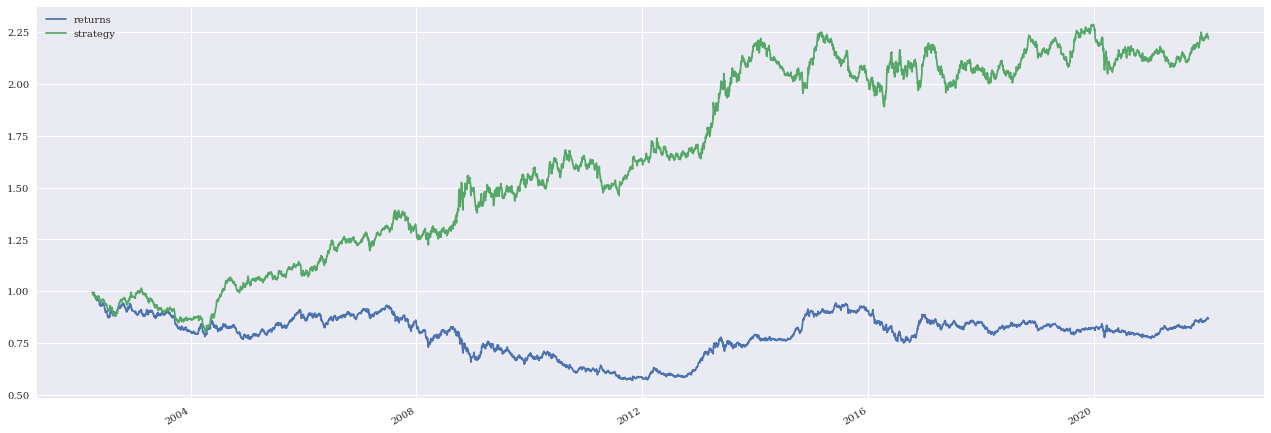

In [ ]:
data['strategy'] = data['prediction'] * data['returns']
data[['returns', 'strategy']].sum().apply(np.exp)

data[['returns', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=figure_size);

#### ラグを変更して結果を確認
lags=5　は過去5回分のリターンを１行のデータとして集める

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

#前日との価格差を対数として表し、それをリターンとした
data['returns'] = np.log(data['price'] / data['price'].shift(1))

data.dropna(inplace=True)

#
lags = 5

cols = []
for lag in range(1, lags + 1) :
   col = 'lag_{}'.format(lag)
   data[col] = data['returns'].shift(lag)
   cols.append(col)

data.dropna(inplace=True)
data[cols]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,lag_1,lag_2,lag_3,lag_4,lag_5
2002-04-09,-0.005685,-0.006029,-0.000751,0.000000,0.000375
2002-04-10,0.000000,-0.005685,-0.006029,-0.000751,0.000000
2002-04-11,-0.006482,0.000000,-0.005685,-0.006029,-0.000751
2002-04-12,0.003056,-0.006482,0.000000,-0.005685,-0.006029
2002-04-15,0.003427,0.003056,-0.006482,0.000000,-0.005685
...,...,...,...,...,...
2022-01-04,0.001131,-0.000696,0.004970,-0.000087,0.001575
2022-01-05,0.003558,0.001131,-0.000696,0.004970,-0.000087
2022-01-06,0.006907,0.003558,0.001131,-0.000696,0.004970
2022-01-07,-0.001550,0.006907,0.003558,0.001131,-0.000696


予測を行いヒット率を表示

In [ ]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

lm.fit(data[cols], np.sign(data['returns']))

data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()

hits = np.sign(data['returns'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()


accuracy_score(data['prediction'],
               np.sign(data['returns']))

0.5081594711836398

予測リターンを表示

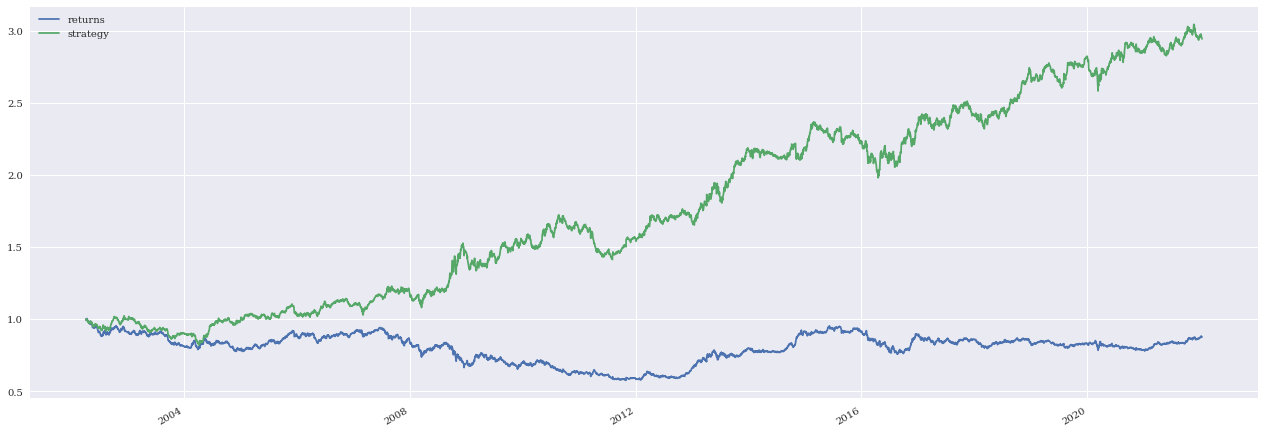

In [ ]:
data['strategy'] = data['prediction'] * data['returns']
data[['returns', 'strategy']].sum().apply(np.exp)

data[['returns', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=figure_size);

### ロジスティック回帰バックテストクラスのカスタマイズ
上記の内容を本書ではClassにしたが、汎用的ではなかったので、汎用的な形で修正した。

MultiDataScikitVectorBacktester.py : 投入できるデータセットが　http://hilpisch.com/pyalgo_eikon_eod_data.csv　のデータのみを利用するものになっていた。

MultiDataScikitVectorBacktester.py : データの形式が同じであれば、どんなデータセットでもバックテストできるように修正した。

これにより、いろいろな期間・データの平均戦略のバックテストが可能になる

ロジスティック回帰の汎用クラスについて
MultiDataScikitVectorBacktester

```
==========
Attributes
==========
    symbol: str
        グラフ表示利用する取引銘柄
    dataset: DataFrame [price] index = date
        インデックスがDateでデータにはprice列に価格が格納されたDataframe
    lags: int
        特徴量として扱う過去リターン数 デフォルト３
    start: str
        データセットとして利用するデータの開始日
    end: str
        データセットとして利用するデータの終了日
    amount: int
        取引数りょう
    tc: float
        取引コスト %
    model: str
        予測モデルを選択できる 'regression' or 'logistic'

=======
　Method
=======
    get_data:
        取得したデータセットから SMAとリターン(1つ前の価格の対数収益率)を計算しDataframeに格納する
    prepare_features:
        特徴量を抽出してベクトル化する
    fit_model:
        モデルの学習を行なう
    run_strategy:
        累積リターンを求める
    plot_results:
        累積リターンを表示する
```

In [ ]:
import MultiDataScikitVectorBacktester as MSIC

線形回帰モデルを利用して予測したシグナルを利用したリターン　　特徴量:過去のリターン３件

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB
(4851.19, -4613.17)


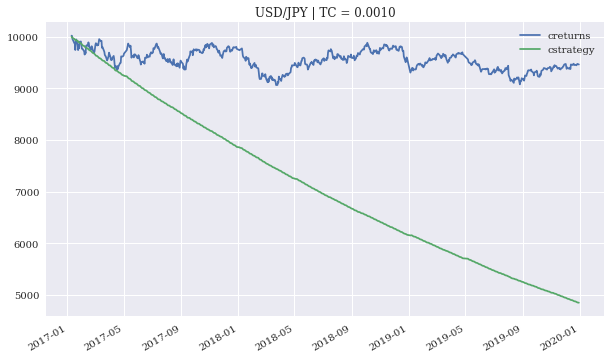

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

scibt = MSIC.MultiDataScikitVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31',
                                   10000, 0.001, 'regression')

print(scibt.run_strategy('2010-01-01', '2016-12-31',
                        '2017-01-01', '2019-12-31'))
scibt.plot_results()

ロジスティック回帰モデルを利用して予測したシグナルを利用したリターン　　特徴量:過去のリターン３件

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB
(8839.01, -625.35)


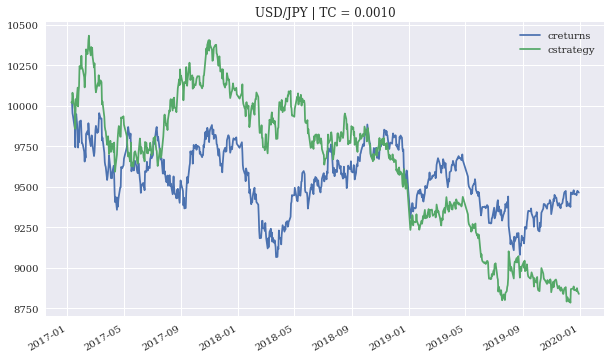

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

scibt = MSIC.MultiDataScikitVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31',
                                   10000, 0.001, 'logistic')

print(scibt.run_strategy('2010-01-01', '2016-12-31',
                        '2017-01-01', '2019-12-31'))
scibt.plot_results()

ロジスティック回帰モデルを利用して予測したシグナルを利用したリターン　　特徴量:過去のリターン５件

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB
(9717.6, 270.38)


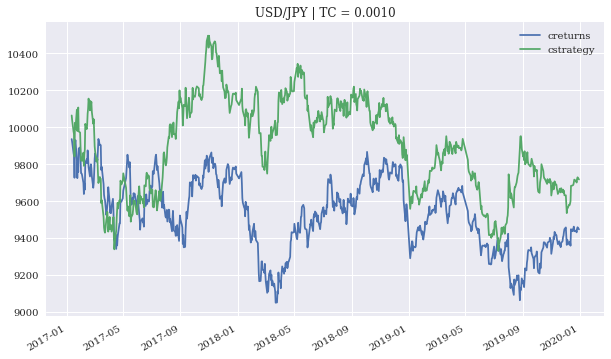

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

scibt = MSIC.MultiDataScikitVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31',
                                   10000, 0.001, 'logistic')

print(scibt.run_strategy('2010-01-01', '2016-12-31',
                        '2017-01-01', '2019-12-31', lags=5))
scibt.plot_results()

ロジスティック回帰モデルを利用して予測したシグナルを利用したリターン　　特徴量:過去のリターン15件

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB
(7080.26, -2551.35)


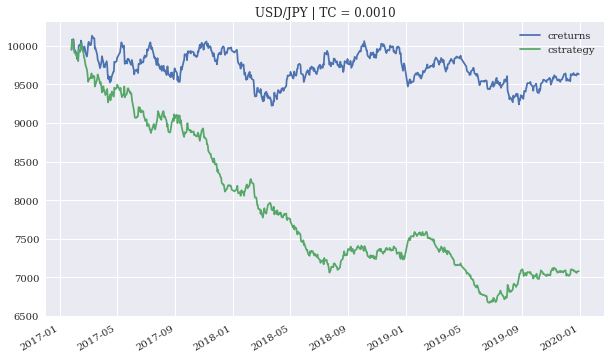

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

scibt = MSIC.MultiDataScikitVectorBacktester('USD/JPY', data, '2010-01-01', '2019-12-31',
                                   10000, 0.001, 'logistic')

print(scibt.run_strategy('2010-01-01', '2016-12-31',
                        '2017-01-01', '2019-12-31', lags=15))
scibt.plot_results()

## DeepLearningでの予測
---

2022/09

Kerasを利用したDeeplearningでのマーケットの動きの予測



### Deeplearningでの分類予測　(sklearn)

例として、学習時間に対するテストの合格・不合格の予測を　Deeplearningで確認する

In [ ]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 

data = pd.DataFrame({'hours': hours, 'success': success})

ニューラルネットワークを利用した予測

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)

model.fit(data['hours'].values.reshape(-1, 1), data['success'])

data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1)) 

data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


 予測結果はロジスティック回帰と同じ

 ハイパーパラメータが異なるがAPIは同じ

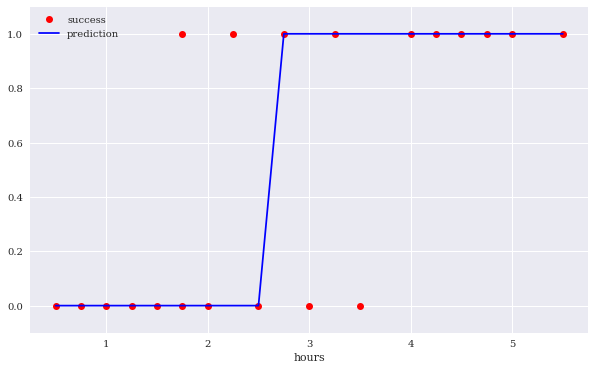

In [ ]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));

### Kerasを使ったマーケットの方向性予測

過去のリターン情報を特徴量としてベクトル化して、その結果を学習して方向性を予測するようにデータを整形

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

data['return'] = np.log(data['price'] / data['price'].shift(1)) 
data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5

cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True)

data.round(4).tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
2022-01-04,115.43,0.0036,1,0.0011,-0.0007,0.0050,-0.0001,0.0016
2022-01-05,116.23,0.0069,1,0.0036,0.0011,-0.0007,0.0050,-0.0001
2022-01-06,116.05,-0.0015,0,0.0069,0.0036,0.0011,-0.0007,0.0050
2022-01-07,116.01,-0.0003,0,-0.0015,0.0069,0.0036,0.0011,-0.0007
2022-01-11,115.34,-0.0058,0,-0.0003,-0.0015,0.0069,0.0036,0.0011


Kerasを利用できるようにimportしている

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam 

*損失関数にAdamを利用する*

損失とはニューラルネットワークによる予測値と正解値との差 

ニューラルネットワークの重みとバイアスの調整を行う関数

In [ ]:
optimizer = Adam(learning_rate=0.0001)

ランダムシードの設定を行う

In [ ]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

Sequentialモデルを利用するためにハイパーパラメータを設定してる

In [ ]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

学習データとテストデータに分けている

In [ ]:
cutoff = '2017-12-31'

training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

モデルの学習を行う

In [ ]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

res = pd.DataFrame(model.history.history)

CPU times: user 14.1 s, sys: 798 ms, total: 14.9 s
Wall time: 21.2 s


どれくらい学習できているか確認する

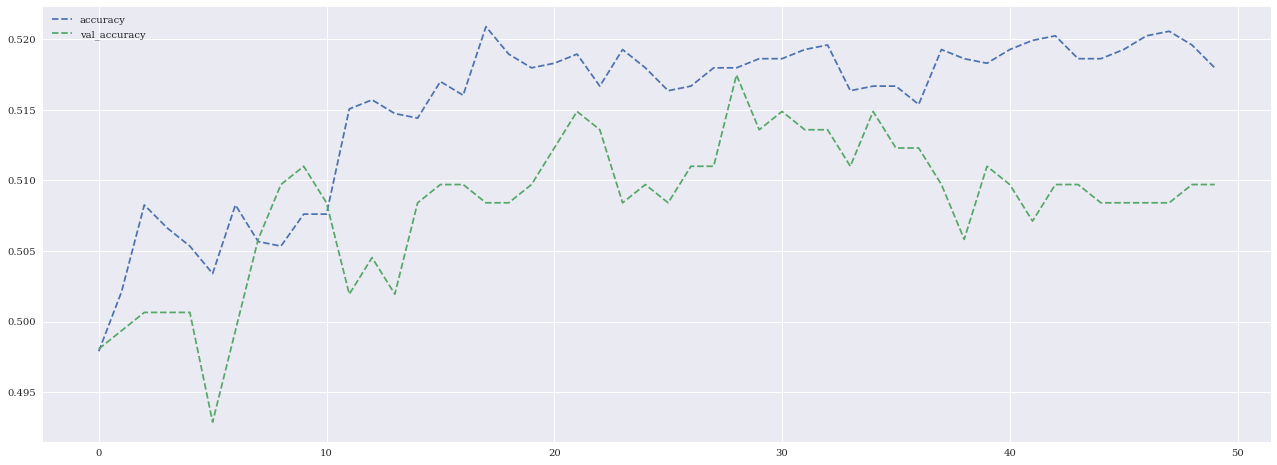

In [ ]:
res[['accuracy', 'val_accuracy']].plot(figsize=figure_size, style='--');

####  学習データを利用して予測した場合の結果を確認する

モデルのパフォーマンスを確認ため、予測を行う

In [ ]:
model.evaluate(training_data_[cols], training_data['direction'])

pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

pred[:30].flatten()

121/121 [==============================] - 0s 1ms/step


array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1])

モデルのパフォーマンスの計算を行う

In [ ]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.859369
strategy    2.707088
dtype: float64


モデルのパフォーマンスを表示する

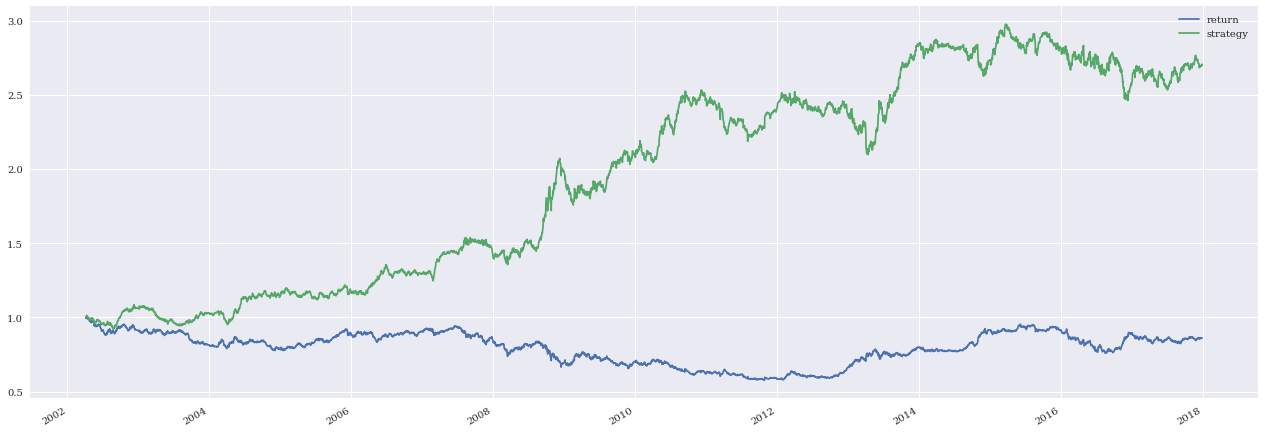

In [ ]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=figure_size);

#### テストデータを利用して予測した場合の結果を確認する
モデルのパフォーマンスを確認ため、予測を行う

In [ ]:
model.evaluate(test_data_[cols], test_data['direction'])

pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

pred[:30].flatten()

31/31 [==============================] - 0s 3ms/step


array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1])

モデルのパフォーマンスの計算を行う

In [ ]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

test_data['strategy'] = (test_data['prediction'] *
                            test_data['return'])

test_data[['return', 'strategy']].sum().apply(np.exp)

return      1.020257
strategy    1.002599
dtype: float64


モデルのパフォーマンスを表示する

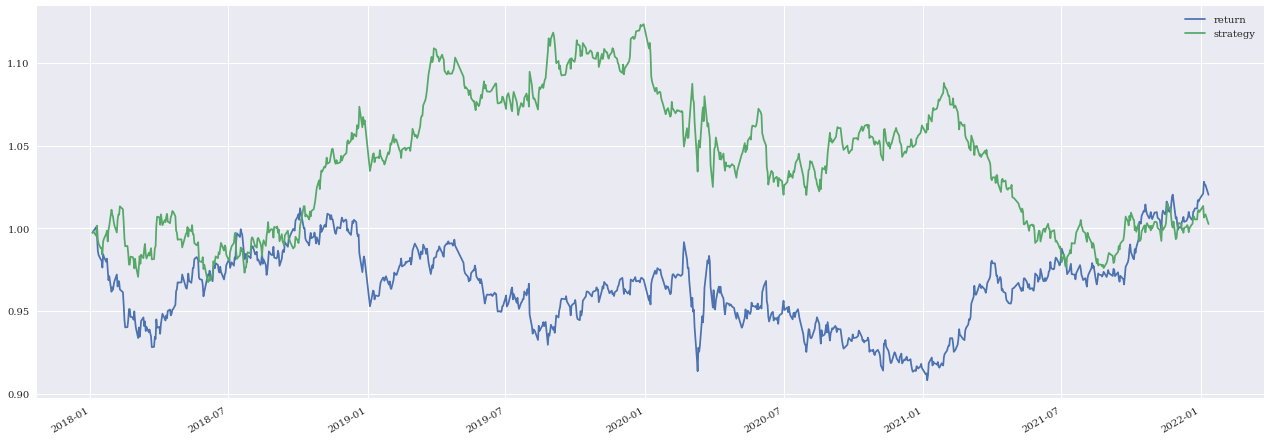

In [ ]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=figure_size);

### 特徴量を追加して予想する

リターンの特徴量を調整する

In [ ]:
data = get_close_data('USD')
data.info()
data.head()

data['return'] = np.log(data['price'] / data['price'].shift(1)) 
data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5

cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True)

data.round(4).tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2002-04-01 to 2022-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4847 non-null   float64
dtypes: float64(1)
memory usage: 75.7 KB


,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
2022-01-04,115.43,0.0036,1,0.0011,-0.0007,0.0050,-0.0001,0.0016
2022-01-05,116.23,0.0069,1,0.0036,0.0011,-0.0007,0.0050,-0.0001
2022-01-06,116.05,-0.0015,0,0.0069,0.0036,0.0011,-0.0007,0.0050
2022-01-07,116.01,-0.0003,0,-0.0015,0.0069,0.0036,0.0011,-0.0007
2022-01-11,115.34,-0.0058,0,-0.0003,-0.0015,0.0069,0.0036,0.0011



追加する特徴量は
- モメンタム.   リターンの5日間移動平均
- ボラティリティ リターンの20日間標準偏差
- 乖離        価格の５０日間移動平均との乖離

In [ ]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)
cols.extend(['momentum', 'volatility', 'distance'])
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
2022-01-04  115.43  0.0036          1  0.0011 -0.0007  0.0050 -0.0001  0.0016   
2022-01-05  116.23  0.0069          1  0.0036  0.0011 -0.0007  0.0050 -0.0001   
2022-01-06  116.05 -0.0015          0  0.0069  0.0036  0.0011 -0.0007  0.0050   
2022-01-07  116.01 -0.0003          0 -0.0015  0.0069  0.0036  0.0011 -0.0007   
2022-01-11  115.34 -0.0058          0 -0.0003 -0.0015  0.0069  0.0036  0.0011   

            momentum  volatility  distance  
2022-01-04    0.0014      0.0022    1.0092  
2022-01-05    0.0018      0.0022    1.4042  
2022-01-06    0.0032      0.0026    2.1652  
2022-01-07    0.0019      0.0026    1.9450  
2022-01-11    0.0019      0.0026    1.8594  


学習データとテストデータに分けている

In [ ]:
cutoff = '2017-12-31'

training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

Sequentialモデルを利用するためにハイパーパラメータを設定してる

In [ ]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

学習を行う

In [ ]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

res = pd.DataFrame(model.history.history)

CPU times: user 13.5 s, sys: 896 ms, total: 14.4 s
Wall time: 12.8 s


#### 学習データを利用して予測した場合の結果を確認する
モデルのパフォーマンスを確認ため、予測を行う

In [ ]:
model.evaluate(training_data_[cols], training_data['direction'])

pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

training_data['prediction'] = np.where(pred > 0, 1, -1)

training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

training_data[['return', 'strategy']].sum().apply(np.exp)

120/120 [==============================] - 0s 1ms/step


return      0.909859
strategy    4.729306
dtype: float64


モデルのパフォーマンスを表示する

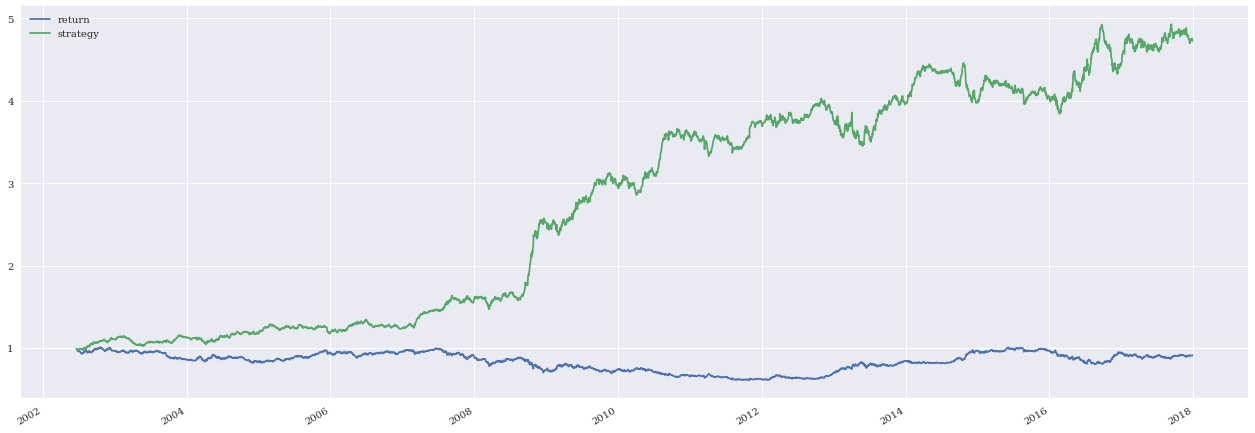

In [ ]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=figure_size);

#### テストデータを利用して予測した場合の結果を確認する
モデルのパフォーマンスを確認ため、予測を行う

In [ ]:
model.evaluate(test_data_[cols], test_data['direction'])

pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0, 1, -1)

test_data['strategy'] = (test_data['prediction'] *
                            test_data['return'])

test_data[['return', 'strategy']].sum().apply(np.exp)

31/31 [==============================] - 0s 2ms/step


return      1.020257
strategy    1.244447
dtype: float64

モデルのパフォーマンスを表示する

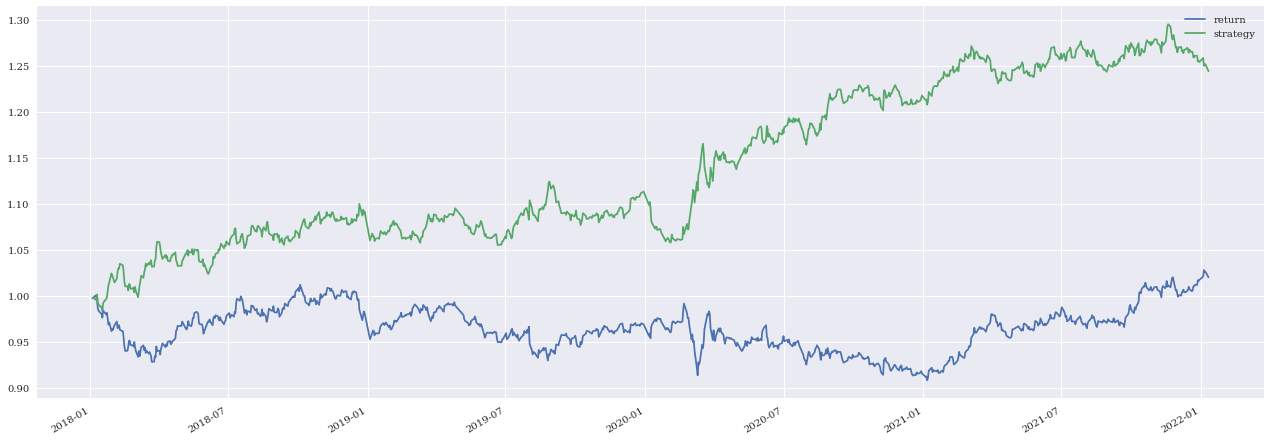

In [ ]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=figure_size);

# イベントベースでのバックテスト
---

 * バックテストのための規定クラス - 2022/10
   * 証拠金計算追加
 * ロングオンリーのバックテストクラス - 2022/10
 * ロングショートのバックテストクラス - 2022/10




## バックテストのための規定クラス
---

2022/10

ティック情報を１データずつ読み込んで、売買のバックテストを行うためのクラスを作成する

ディック情報は、日足、分足、ティックでも可能にする

取引制限により、ロングしか持てない場合と、証拠金取引のようにロングとショート両方持てる場合に分けてクラスを作成する

固定コスト、変動コスト、証拠金などを加味した形でバックテストできるように計算ロジックを関数化して組み込む


### BacktestBase：規定クラスで作成されている関数：
* __init__：初期設定
* データ制御
 * get_data：バックテストデータ取得   <- 為替のデータをダウンロードするように修正
 * plot_data：バックテストデータのグラグを表示する
 * get_date_price：バックテストデータから指定日時のデータを取得する
 * print_balance：現金残高を表示する
 * print_net_wealth： 口座の時価評価を表示する
 * get_margin_amount：証拠金の計算を行い表示する
 * get_swap_amount:スワップの計算を行い表示する
* 売買
 * place_buy_order：新規買い
 * place_sell_order：新規売り
 * close_out：ポジションクローズ


##### __init__：初期設定

In [ ]:
    def __init__(self, symbol, start, end, unit, amount,
                 ftc=0.0, ptc=0.0, verbose=True):
        self.symbol = symbol # dataのシンボルを登録、主にグラフ表示に利用
        self.start = start # ティックデータの開始
        self.end = end # ティックデータの終了
        self.initial_amount = amount # 初期投資額を設定
        self.amount = amount # 投資額の変動を計算するための変数
        self.ftc = ftc # 1トレードの固定取引コスト
        self.ptc = ptc # 1トレードの比例取引コスト
        self.units = unit # 投資商品の保有単位
        self.position = 0 # ポジション
        self.trades = 0 # 取引回数
        self.verbose = verbose
        self.get_data()

        return 

##### get_data：バックテストデータ取得 <- 為替のデータをダウンロードするように修正

In [ ]:
    def get_data(self):
        ''' Retrieves and prepares the data.

        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
        '''

        # データダウンロード
        url = 'https://www.mizuhobank.co.jp/market/quote.csv'
        res = requests.get(url)
        df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",",header=[2])
        # データを整形
        df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})

        dataset = pd.DataFrame(df_tmp[self.symbol].tolist(),columns=['price'],
                           index=pd.to_datetime(df_tmp['Date']).tolist())
        dataset['price'] = dataset['price'].astype(np.float64)
        dataset = dataset.loc[self.start:self.end]
        dataset['return'] = np.log(dataset / dataset.shift(1))

        self.data = dataset.dropna()

##### plot_data：バックテストデータのグラフを表示する

In [ ]:
    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data[cols].plot(figsize=(22, 8), title=self.symbol)


##### get_date_price：バックテストデータから指定日時のデータを取得する

In [ ]:
   def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price

##### print_balance : 保有している数量を表示する

In [ ]:
    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')

##### print_net_wealth : 時価評価を表示する

In [ ]:
    def print_net_wealth(units,amount, bar):
        ''' Print out current cash balance info.
        '''
        date, price = get_date_price(bar)
        net_wealth = nits * price + amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

##### place_buy_order : 買い注文を行う

In [ ]:
def place_buy_order(self, bar, units=None, amount=None):
  ''' Place a buy order.
  '''
  date, price = self.get_date_price(bar)
  if units is None:
    units = int(amount / price) # 取引数量を現金残高と価格の割合で算出する
  self.amount -= (units * price) * (1 + self.ptc) + self.ftc # 現在の現金残高　投資商品を購入するための現金支出と、比例及び固定取引コストの分だけ減少させる
  self.units += units # 購入した数量分増加
  self.trades += 1 # 取引数をインクリメント
  if self.verbose: # 取引を行なった時の口座状況を表示するための処理
    print(f'{date} | buying {units} units at {price:.2f}')
    self.print_balance(bar)
    self.print_net_wealth(bar)

place_sell_order : 売り注文を行う

In [ ]:
    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

##### close_out : ポジションをクローズする

In [ ]:
def close_out(self, bar):
  ''' Closing out a long or short position.
  '''
  date, price = self.get_date_price(bar)
  self.amount += self.units * price
  self.units = 0
  self.trades += 1
  if self.verbose:
    print(f'{date} | inventory {self.units} units at {price:.2f}')
    print('=' * 55)
  print('Final balance   [$] {:.2f}'.format(self.amount))
  perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
  print('Net Performance [%] {:.2f}'.format(perf))
  print('Trades Executed [#] {}'.format(self.trades))
  print('=' * 55)

#### BacktestBase class

上記の関数をclassにまとめたもの　lib に保存したものを呼び出す

In [ ]:

class BacktestBase(object):
    ''' Base class for event-based backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to be used
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: float
        amount to be invested either once or per trade
    ftc: float
        fixed transaction costs per trade (buy or sell)
    ptc: float
        proportional transaction costs per trade (buy or sell)

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    plot_data:
        plots the closing price for the symbol
    get_date_price:
        returns the date and price for the given bar
    print_balance:
        prints out the current (cash) balance
    print_net_wealth:
        prints out the current net wealth
    place_buy_order:
        places a buy order
    place_sell_order:
        places a sell order
    close_out:
        closes out a long or short position
    '''

    def __init__(self, symbol, start, end, unit, amount,
                 ftc=0.0, ptc=0.0, verbose=True):
        self.symbol = symbol # dataのシンボルを登録、主にグラフ表示に利用
        self.start = start # ティックデータの開始
        self.end = end # ティックデータの終了
        self.initial_amount = amount # 初期投資額を設定
        self.amount = amount # 投資額の変動を計算するための変数
        self.ftc = ftc # 1トレードの固定取引コスト
        self.ptc = ptc # 1トレードの比例取引コスト
        self.units = unit # 投資商品の保有単位
        self.position = 0 # ポジション
        self.trades = 0 # 取引回数
        self.verbose = verbose
        self.get_data()

    # 利用しない
    def get_data(self):
        ''' Retrieves and prepares the data.

        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
        '''

        # データダウンロード
        url = 'https://www.mizuhobank.co.jp/market/quote.csv'
        res = requests.get(url)
        df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",",header=[2])
        # データを整形
        df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})

        dataset = pd.DataFrame(df_tmp[self.symbol].tolist(),columns=['price'],
                           index=pd.to_datetime(df_tmp['Date']).tolist())
        dataset['price'] = dataset['price'].astype(np.float64)
        dataset = dataset.loc[self.start:self.end]
        dataset['return'] = np.log(dataset / dataset.shift(1))

        self.data = dataset.dropna()

    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data[cols].plot(figsize=(22, 8), title=self.symbol)

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        self.trades += 1
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        print('Net Performance [%] {:.2f}'.format(perf))
        print('Trades Executed [#] {}'.format(self.trades))
        print('=' * 55)


## ロングのみのイベントベースのバックテスト

---

2022/10

ポジションを取る場合にロングのみしか取れない制限がある場合のバックテスト

### SMAを利用した戦略

In [ ]:
    def run_sma_strategy(self, SMA1, SMA2):
        ''' Backtesting a SMA-based strategy.

        Parameters
        ==========
        SMA1, SMA2: int
            shorter and longer term simple moving average (in days)
        '''
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):

            if self.position == 0:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]: # 短期SMAの値が長期SMAより大きくなった場合
                    self.place_buy_order(bar, amount=self.amount) # 現在の残高で買い注文を行う
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]: # 長期SMAの値が短期SMAより大きくなった場合
                    self.place_sell_order(bar, units=self.units) # 現在のポジションを全部売り注文する　 
                    self.position = 0  # market neutral
        self.close_out(bar)

### モメンタムを利用した戦略

In [ ]:

    def run_momentum_strategy(self, momentum):
        ''' Backtesting a momentum-based strategy.

        Parameters
        ==========
        momentum: int
            number of days for mean return calculation
        '''
        msg = f'\n\nRunning momentum strategy | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):

            if self.position == 0:
                if self.data['momentum'].iloc[bar] > 0: # モメンタムが＋の場合
                    self.place_buy_order(bar, amount=self.amount) # 現在の残高で買い注文を行う　 
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['momentum'].iloc[bar] < 0: # モメンタムが-の場合
                    self.place_sell_order(bar, units=self.units) # 現在のポジションを全部売り注文する　 
                    self.position = 0  # market neutral
        self.close_out(bar)

### 平均回帰を利用した戦略

In [ ]:
    def run_mean_reversion_strategy(self, SMA, threshold):
        ''' Backtesting a mean reversion-based strategy.

        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        '''
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0
        self.trades = 0
        self.amount = self.initial_amount

        self.data['SMA'] = self.data['price'].rolling(SMA).mean() # 移動平均を求める

        for bar in range(SMA, len(self.data)): # SMAのデータの存在範囲のティックデータを順番に取得する
            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.place_buy_order(bar, amount=self.amount) # 現在の残高で買い注文を行う　 
                    self.position = 1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]: # 現在のポジションを全部売り注文する
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
        self.close_out(bar)

### BacktestLongOnly Class
Jyupter上で動作させるために読み込み

In [ ]:

class BacktestLongOnly(BacktestBase):

    def run_plot_data(self):
        self.plot_data()

    def run_sma_strategy(self, SMA1, SMA2):
        ''' Backtesting a SMA-based strategy.

        Parameters
        ==========
        SMA1, SMA2: int
            shorter and longer term simple moving average (in days)
        '''
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):

            if self.position == 0:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        ''' Backtesting a momentum-based strategy.

        Parameters
        ==========
        momentum: int
            number of days for mean return calculation
        '''
        msg = f'\n\nRunning momentum strategy | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position == 0:
                if self.data['momentum'].iloc[bar] > 0:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['momentum'].iloc[bar] < 0:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        ''' Backtesting a mean reversion-based strategy.

        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        '''
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0
        self.trades = 0
        self.amount = self.initial_amount

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):

            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
        self.close_out(bar)


### イベントベースバックテストの実行 ロングのみ
* SMAでのイベントベースバックテスト
  * SMAの２区間の期間を指定　42日と２５２日のクロス
* モメンタムでのイベントベースバックテスト
 * 60日期間の平均収益率
* 平均回帰でのイベントベースバックテスト
 * SMAの期間を50日
 * シグナル発生閾値 5


In [ ]:
def run_strategies():
    lobt.run_plot_data()
    lobt.run_sma_strategy(42, 252)
    lobt.run_momentum_strategy(60)
    lobt.run_mean_reversion_strategy(50, 5)

#### 取引コストを無視したイベントベースでのバックテスト



Running SMA strategy | SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 11548.08
Net Performance [%] 15.48
Trades Executed [#] 13


Running momentum strategy | 60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 14552.02
Net Performance [%] 45.52
Trades Executed [#] 134


Running mean reversion strategy | SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 10422.78
Net Performance [%] 4.23
Trades Executed [#] 7


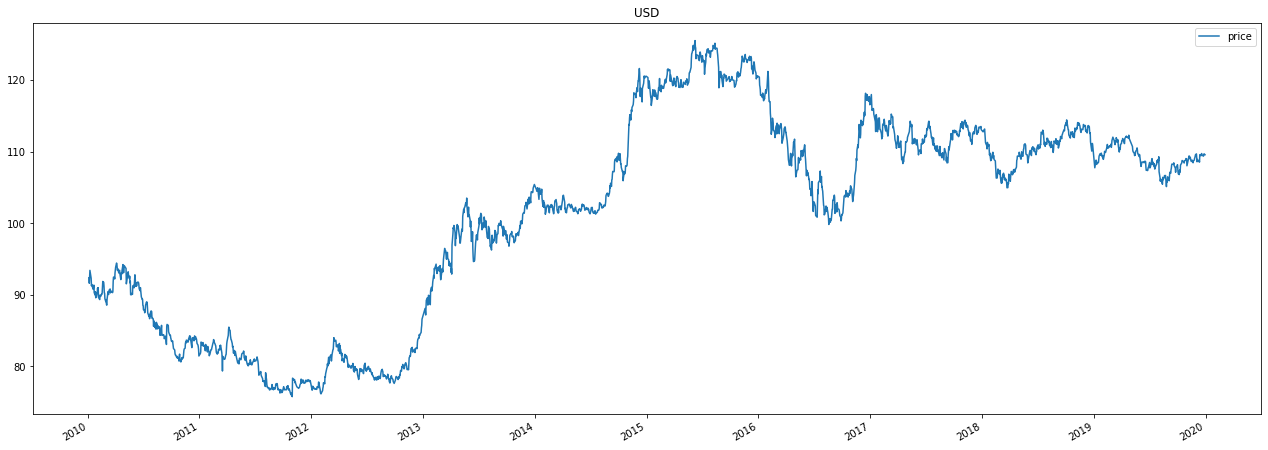

In [ ]:
lobt = BacktestLongOnly('USD', '2010-０1-01', '2019-12-31', 0, 10000, verbose=False)

run_strategies()

#### 取引コストを意識したイベントベースでのバックテスト



Running SMA strategy | SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 10112.89
Net Performance [%] 1.13
Trades Executed [#] 13


Running momentum strategy | 60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 2992.10
Net Performance [%] -70.08
Trades Executed [#] 134


Running mean reversion strategy | SMA=50 & thr=5
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 9756.05
Net Performance [%] -2.44
Trades Executed [#] 7


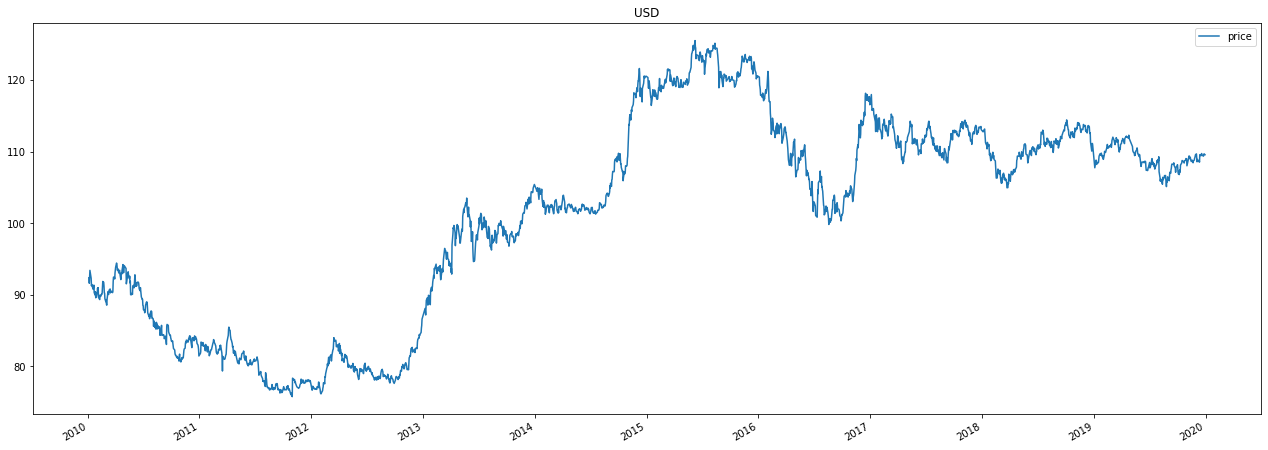

In [ ]:
lobt = BacktestLongOnly('USD', '2010-01-01', '2019-12-31', 0,
                            10000, 10.0, 0.01, False)
run_strategies()

## ロング・ショートのイベントベースのバックテスト
---

2022/10

ポジションを取る場合にロングとショート両方取れる場合のバックテスト

### SMAを利用した戦略

売りポジション持ちかニュートラルで買いシグナルがあったら決済して買いポジションを持てるだけもつ

買いポジション持ちかニュートラルで売りシグナルがあったら決済して売いポジションを持てるだけもつ

In [ ]:
    def run_sma_strategy(self, SMA1, SMA2):
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):

            if self.position in [0, -1]:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)


### モメンタムを利用した戦略

売りポジション持ちかニュートラルで買いシグナルがあったら決済して買いポジションを持てるだけもつ

買いポジション持ちかニュートラルで売りシグナルがあったら決済して売いポジションを持てるだけもつ

In [ ]:
    def run_momentum_strategy(self, momentum):
        msg = f'\n\nRunning momentum strategy | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):

            if self.position in [0, -1]:
                if self.data['momentum'].iloc[bar] > 0:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['momentum'].iloc[bar] <= 0:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

### 平均回帰を利用した戦略
この戦略だけは、ポジションがニュートラルになる場合がある

In [ ]:
    def run_mean_reversion_strategy(self, SMA, threshold):
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):

            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.go_long(bar, amount=self.initial_amount)
                    self.position = 1
                elif (self.data['price'].iloc[bar] >
                        self.data['SMA'].iloc[bar] + threshold):
                    self.go_short(bar, amount=self.initial_amount)
                    self.position = -1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
            elif self.position == -1:
                if self.data['price'].iloc[bar] <= self.data['SMA'].iloc[bar]:
                    self.place_buy_order(bar, units=-self.units)
                    self.position = 0
        self.close_out(bar)

### BacktestLongOnly Class
Jyupter上で動作させるために読み込み

In [ ]:
class BacktestLongShort(BacktestBase):

    # 売りポジションがあったら決済して買いポジションを持てるだけもつ
    def go_long(self, bar, units=None, amount=None):
        if self.position == -1:
            self.place_buy_order(bar, units=-self.units)
        if units:
            self.place_buy_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_buy_order(bar, amount=amount)

    def go_short(self, bar, units=None, amount=None):
        if self.position == 1:
            self.place_sell_order(bar, units=self.units)
        if units:
            self.place_sell_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_sell_order(bar, amount=amount)

    def run_sma_strategy(self, SMA1, SMA2):
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):

            if self.position in [0, -1]:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        msg = f'\n\nRunning momentum strategy | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):

            if self.position in [0, -1]:
                if self.data['momentum'].iloc[bar] > 0:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['momentum'].iloc[bar] <= 0:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):

            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.go_long(bar, amount=self.initial_amount)
                    self.position = 1
                elif (self.data['price'].iloc[bar] >
                        self.data['SMA'].iloc[bar] + threshold):
                    self.go_short(bar, amount=self.initial_amount)
                    self.position = -1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
            elif self.position == -1:
                if self.data['price'].iloc[bar] <= self.data['SMA'].iloc[bar]:
                    self.place_buy_order(bar, units=-self.units)
                    self.position = 0
        self.close_out(bar)

### イベントベースバックテストの実行 ロング・ショート
* SMAでのイベントベースバックテスト
  * SMAの２区間の期間を指定 42日と252日のクロス
* モメンタムでのイベントベースバックテスト
 * 60日期間の平均収益率
* 平均回帰でのイベントベースバックテスト
 * SMAの期間を50日
 * シグナル発生閾値 5


In [ ]:
def run_strategies():
  lsbt.run_sma_strategy(42, 252)
  lsbt.run_momentum_strategy(60)
  lsbt.run_mean_reversion_strategy(50, 5)

#### 取引コストを無視したイベントベースでのバックテスト

In [ ]:
lsbt = BacktestLongShort('USD', '2010-01-01', '2019-12-31', 0, 10000,
                             verbose=False)
run_strategies()



Running SMA strategy | SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 10053.79
Net Performance [%] 0.54
Trades Executed [#] 26


Running momentum strategy | 60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 17516.30
Net Performance [%] 75.16
Trades Executed [#] 266


Running mean reversion strategy | SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 9292.16
Net Performance [%] -7.08
Trades Executed [#] 17


#### 取引コストを意識したイベントベースでのバックテスト

In [ ]:
lsbt = BacktestLongShort('USD', '2010-01-01', '2019-12-31', 0,
                             10000, 10.0, 0.01, False)
run_strategies()

# リアルタイムデータとソケットを扱う
--- 
2022/10

リアルタイムデータのシミュレーションを行うために、ティックサーバを立てる

ティックサーバには、ZeroMQを利用する 

ストリーミングサーバの一つで、ブローカーを持たない。

サーバをPUB / クライアントをSUBとして通信する方式で実装



## ティッククサーバの作成

ティックを生成するモデルは、オイラー法によるブラウン運動

式

$$
    St = S_{t-Δt} ~ exp((r - \frac{σ^2}{2}) Δt + \sqrt{Δtz})
$$


パラメータは
* S は商品価格
* r は短期金利
* σ はボラティリティ
* z は標準正規確率
* Δt は商品価格の時間間隔


関連記事：https://www.u-tokyo.ac.jp/focus/ja/features/f_00022.html

### ティックサーバ

ティックサーバとブラウン運動での価格生成を行なっている

InstrumentPriceは、シミュレーションによってティックデータを生成している

ティックデータの発行間隔と価格がランダムに発行される

In [ ]:
#
import zmq
import math
import time
import random
import numpy as np
import pandas as pd

context = zmq.Context()
socket = context.socket(zmq.PUB)
socket.bind('tcp://0.0.0.0:5555')

class InstrumentPrice(object):
    def __init__(self):
        self.symbol = 'SYMBOL'
        self.t = time.time() # 生成日時
        self.value = 145. # ブラウン運動で価格を生成するための基準価格
        self.sigma = 0.4 # ボラティリティ
        self.r = 0.01    # 短期金利 

    def simulate_value(self):
        ''' Generates a new, random stock price.
        '''
        t = time.time() # 
        dt = (t - self.t) / (252 * 8 * 60 * 60) # 現在時刻　と 前回の出力時間の差を 1年の取引営業日時間を秒　割った値
        dt *= 500 # Δtの値をパタメータにより調整している 
        self.t = t
        self.value *= math.exp((self.r - 0.5 * self.sigma ** 2) * dt +
                               self.sigma * math.sqrt(dt) * random.gauss(0, 1)) # 価格を計算して算出する
        return self.value


ip = InstrumentPrice()

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    print(msg)
    socket.send_string(msg) # メッセージをソケットで送信
    time.sleep(random.random() * 2)

SYMBOL 145.00
SYMBOL 145.05
SYMBOL 144.98
SYMBOL 144.33


KeyboardInterrupt: ignored

### ティックサーバのクライアント
クライアントは、サーバに接続して値を取得しているだけ

In [ ]:
import zmq

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

while True:
    data = socket.recv_string() # ソケットで受け取った情報を出力している
    print(data)


## リアルタイムでシグナル生成
--- 
2022/11

リアルタイムでシグナル生成することをオンラインアルゴリズムという先読み要素が排除されているので現実的な運用となる

ティックデータを収集してシグナルを生成し、通知する機能

今回取り上げるのは、
* モメンタムのリアルタイムシグナル生成



### クライアントでのリアルタムシグナル生成実装

1. 受信したティックデータを保存するデータフレームを作成
2. テクになるのパラメータを指定

-- 繰り返し -- 
3. ティックデータを取得して、取得したデータとタイムスタンプをデータフレームに登録
4. ５秒間隔でリサンプリングし、最後に得られたティックから対数リターンを求める
5. シグナル計算に必要なデータが集まったらシグナル生成する


#### モメンタムのリアルタイムシグナル生成
直近の取引の対数リターンがプラスだったら買い、マイナスだったら売り

* モメンタムを計算する期間は、5つの対数リターンデータの平均が絶対値１を超えていた場合にシグナル発生
* 売買シグナルが最短５秒間隔で出る
* モメンタムが１.０の場合は買い、−1.0の場合は売り
* 最後のモメンタムの値はリサンプリング途中の値が入っている可能性があるので２番目の値を利用する

In [ ]:
import zmq
import datetime
import numpy as np
import pandas as pd

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

df = pd.DataFrame()
mom = 5
min_length = mom + 1
position = 0

while True:
    data = socket.recv_string()
    t = datetime.datetime.now()
    sym, value = data.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))
    if len(dr) > min_length:
        min_length += 1
        dr['momentum'] = np.sign(dr['returns'].rolling(mom).mean())
        #print(dr.iloc[:-1].tail())
        if dr['momentum'].iloc[-2] == 1.0:

          if position in [0, -1]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Long market position.\n')
            # take some action (e.g. place buy order)
            positon = 1

        if dr['momentum'].iloc[-2] == -1.0:
           
          if position in [0, 1]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Short market position.\n')
            # take some action (e.g. place sell order)
            positon = -1

KeyboardInterrupt: ignored

#### モメンタムのリアルタイムシグナル生成 動作確認
サーバサイドで動かして動作を確認する

In [ ]:
ip = InstrumentPrice()
df = pd.DataFrame()
mom = 5
min_length = mom + 1
position = 0

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    time.sleep(random.random() * 2)
    
    t = datetime.datetime.now()
    sym, value = msg.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))

    if len(dr) > min_length:
        min_length += 1
        print(msg)
        dr['momentum'] = np.sign(dr['returns'].rolling(mom).mean())
        #print(dr.iloc[:-1].tail())
        if dr['momentum'].iloc[-2] == 1.0:

          if position in [0, -1]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Long market position.\n')
            # take some action (e.g. place buy order)
            position = 1

        if dr['momentum'].iloc[-2] == -1.0:
           
          if position in [0, 1]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Short market position.\n')
            # take some action (e.g. place sell order)
            position = -1

KeyboardInterrupt: ignored

#### SMAのリアルタイムシグナル生成 ソケットクライアン
短期SMAと長期SMAの値が逆転した場合に、短期SMAが長期SMAを上回った買い、短期SMAが長期SMAを下回った売り

* SMAを計算する期間は、短期が１２ティック、２６ティックでシグナルを評価する
* 売買シグナルが最短５秒間隔で出る
* 最後のSMAの値はリサンプリング途中の値が入っている可能性があるので２番目の値を利用する

In [ ]:
import zmq
import datetime
import numpy as np
import pandas as pd

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

df = pd.DataFrame()
sma1 = 12
sma2 = 26
min_length = sma2 + 1
position = 0

while True:
    data = socket.recv_string()
    t = datetime.datetime.now()
    sym, value = data.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))
    if len(dr) > min_length:
        min_length += 1
        dr['sma1'] = np.sign(dr['SYMBOL'].rolling(sma1).mean())
        dr['sma2'] = np.sign(dr['SYMBOL'].rolling(sma2).mean())
        #print(dr.iloc[:-1].tail())

        if dr['sma1'].iloc[-2] > dr['sma2'].iloc[-2] :
            
            if position in [0, -1]:
              print('\n' + '=' * 51)
              print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
              print('Long market position.\n')
              # take some action (e.g. place buy order)
              position = 1

        if dr['sma1'].iloc[-2] < dr['sma2'].iloc[-2] :

           if position in [0, 1]:
              print('\n' + '=' * 51)
              print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
              print('Short market position.\n')
              # take some action (e.g. place sell order)
              position = -1

#### SMAのリアルタイムシグナル生成 動作確認
サーバサイドで動かして動作を確認する

In [ ]:
ip = InstrumentPrice()
df = pd.DataFrame()
sma1 = 12
sma2 = 26
min_length = sma2 + 1
position = 0

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    time.sleep(random.random() * 2)

    t = datetime.datetime.now()
    sym, value = msg.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))
    
    if len(dr) > min_length:
        print(msg)
        min_length += 1
        dr['sma1'] = dr['SYMBOL'].rolling(sma1).mean()
        dr['sma2'] = dr['SYMBOL'].rolling(sma2).mean()
        #print(dr.iloc[:-1].tail())
        if dr['sma1'].iloc[-2] > dr['sma2'].iloc[-2] :
            
            if position in [0, -1]:
              print('\n' + '=' * 51)
              print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
              print('Long market position.\n')
              # take some action (e.g. place buy order)
              position = 1

        if dr['sma1'].iloc[-2] < dr['sma2'].iloc[-2] :

            if position in [0, 1]:
              print('\n' + '=' * 51)
              print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
              print('Short market position.\n')
              # take some action (e.g. place sell order)
              position = -1

#### 平均回帰のリアルタイムシグナル生成  ソケットクライアント
SMAと現在レートとの差に長期SMAの値が逆転した場合に、短期SMAが長期SMAを上回った買い、短期SMAが長期SMAを下回った売り

* SMAを計算する期間は、20ティックでシグナルを評価する
* 売買シグナルが最短５秒間隔で出る
* 乖離の閾値は０.５


In [ ]:
import zmq
import datetime
import numpy as np
import pandas as pd

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

df = pd.DataFrame()
sma = 20
threshold = 0.5
min_length = sma + 1
position = 0

while True:
    data = socket.recv_string()
    t = datetime.datetime.now()
    sym, value = data.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))

    if len(dr) > min_length:
        print(msg)
        min_length += 1
        dr['sma'] = dr['SYMBOL'].rolling(sma).mean()
        #print(dr.iloc[:-1].tail())
        if position == 0:
          if (dr['SYMBOL'].iloc[-2] < dr['sma'].iloc[-2] - threshold):
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Long market position.\n')
            # take some action (e.g. place buy order)
            position = 1
          elif (dr['SYMBOL'].iloc[-2] > dr['sma'].iloc[-2] + threshold):
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Short market position.\n')
            position = -1
        elif position == 1:
          if dr['SYMBOL'].iloc[-2] >= data['sma'].iloc[-2]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Neutral market position.\n')
            position = 0
        elif position == -1:
          if dr['SYMBOL'].iloc[-2] <= dr['sma'].iloc[-2]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Neutral market position.\n')
            position = 0

#### 平均回帰のリアルタイムシグナル生成 動作確認
サーバサイドで動かして動作を確認する

In [ ]:
ip = InstrumentPrice()
df = pd.DataFrame()
sma = 20
threshold = 0.5
min_length = sma + 1
position = 0

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    time.sleep(random.random() * 2)

    t = datetime.datetime.now()
    sym, value = msg.split()
    df = df.append(pd.DataFrame({sym: float(value)}, index=[t]))
    dr = df.resample('5s', label='right').last()
    dr['returns'] = np.log(dr / dr.shift(1))
    
    if len(dr) > min_length:
        print(msg)
        min_length += 1
        dr['sma'] = dr['SYMBOL'].rolling(sma).mean()
        #print(dr.iloc[:-1].tail())
        if position == 0:
          if (dr['SYMBOL'].iloc[-2] < dr['sma'].iloc[-2] - threshold):
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Long market position.\n')
            # take some action (e.g. place buy order)
            position = 1
          elif (dr['SYMBOL'].iloc[-2] > dr['sma'].iloc[-2] + threshold):
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Short market position.\n')
            position = -1
        elif position == 1:
          if dr['SYMBOL'].iloc[-2] >= dr['sma'].iloc[-2]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Neutral market position.\n')
            position = 0
        elif position == -1:
          if dr['SYMBOL'].iloc[-2] <= dr['sma'].iloc[-2]:
            print('\n' + '=' * 51)
            print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
            print('Neutral market position.\n')
            position = 0

KeyboardInterrupt: ignored

## ストリーミングデータの可視化
---
2022/11

ソケットから受信したデータをグラフに表示してリアルタイムで更新する

1. Ploty か graph objectをインポートする
2. ソケットを接続する

-- 繰り返し --

3. 受信したデータを整形し、データフレームに保存
4. データフレームをグラフオブジェクトに渡して描画

### ストリーミングデータの自動更新

#### ploty でのグラフのリアルタイム更新 ソケットクライアント


In [ ]:
import zmq
import datetime
import plotly.graph_objs as go

symbol = 'SYMBOL'

fig = go.FigureWidget()
fig.add_scatter()
fig

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

times = list()
prices = list()

for _ in range(50):
  msg = socket.recv_string()
  t = datetime.datetime.now()
  times.append(t)
  _, price = msg.split()
  prices.append(float(price))
  fig.data[0].x = times
  fig.data[0].y = prices

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### ploty でのグラフのリアルタイム更新 動作確認

jypyternotebook　で部分更新がうまくいかずカクカクする

In [ ]:
!pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 16.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
import datetime
import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
plotly.__version__

# creating a figure widget. this will be updated in later cells
fig = go.FigureWidget()
fig.add_scatter()
#juptyer notebook ではない場合は
#fig

times = list()
prices = list()

ip = InstrumentPrice()

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    time.sleep(random.random() * 2)
    t = datetime.datetime.now()
    times.append(t)
    _, price = msg.split()
    prices.append(float(price))
    #juptyer notebook の場合に必要
    clear_output(wait = True)
    fig.data[0].x = times
    fig.data[0].y = prices
    #juptyer notebook の場合に必要
    fig.show()
      

KeyboardInterrupt: ignored

#### matplotlib でのグラフのリアルタイム更新　動作確認
jypyternotebook　で部分更新がうまくいかずカクカクする

In [ ]:
%matplotlib inline

#Plot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

ip = InstrumentPrice()
# Plot
plt.ion()
fig = plt.figure(figsize=(30,8))

while True:
    msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
    time.sleep(random.random() * 2)
    t = datetime.datetime.now()
    times.append(t)
    _, price = msg.split()
    prices.append(float(price))

    # Plot
    clear_output(wait = True)
    plt.ylim(max(prices) + 0.5, min(prices) - 0.5 )   # y軸範囲
    plt.plot(times, prices)
    plt.title("RealTimePrice")  # グラフタイトル
    plt.xlabel("DateTime")     # x軸ラベル
    plt.ylabel("Price")     # y軸ラベル
    plt.grid()
    display(fig)
    plt.cla() # 現在のグラフを消去する

### 3つのリアルタイムストリーム更新


#### ploty での3つのリアルタイムストリームのグラフのリアルタイム更新 ソケットクライアント

In [ ]:
import zmq
import datetime
import pandas as pd
import plotly.graph_objs as go

symbol = 'SYMBOL'

fig = go.FigureWidget()
fig.add_scatter(name=symbol)
fig.add_scatter(name='SMA1',line=dict(width=1,dash='dot'),mode='lines+markers')
fig.add_scatter(name='SMA2',line=dict(width=1,dash='dash'),mode='lines+markers')
fig

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

df = pd.DataFrame()

for _ in range(75):
  msg = socket.recv_string()
  t = datetime.datetime.now()
  sym, price = msg.split()
  df = df.append(pd.DataFrame({sym: float(price)}, index=[t]))
  df['SMA1'] = df[sym].rolling(5).mean()
  df['SMA2'] = df[sym].rolling(10).mean()
  fig.data[0].x = df.index
  fig.data[1].x = df.index
  fig.data[2].x = df.index
  fig.data[0].y = df[sym]
  fig.data[1].y = df['SMA1']
  fig.data[2].y = df['SMA2']

#### ploty での3つのストリームグラフのリアルタイム更新 動作確認

jypyternotebook　で部分更新がうまくいかずカクカクする

In [ ]:
import datetime
import time
import random
import pandas as pd
from IPython.display import clear_output
import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
plotly.__version__

symbol = 'SYMBOL'

fig = go.FigureWidget()
fig.add_scatter(name=symbol)
fig.add_scatter(name='SMA1',line=dict(width=1,dash='dot'),mode='lines+markers')
fig.add_scatter(name='SMA2',line=dict(width=1,dash='dash'),mode='lines+markers')
fig

df = pd.DataFrame()

ip = InstrumentPrice()

while True:
  msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
  time.sleep(random.random() * 2)
  t = datetime.datetime.now()
  sym, price = msg.split()
  df = df.append(pd.DataFrame({sym: float(price)}, index=[t]))
  df['SMA1'] = df[sym].rolling(5).mean()
  df['SMA2'] = df[sym].rolling(10).mean()
  #juptyer notebook の場合に必要
  clear_output(wait = True)
  fig.data[0].x = df.index
  fig.data[1].x = df.index
  fig.data[2].x = df.index
  fig.data[0].y = df[sym]
  fig.data[1].y = df['SMA1']
  fig.data[2].y = df['SMA2']
  #juptyer notebook の場合に必要
  fig.show()
      

#### matplotlib での3つのストリームグラフのリアルタイム更新 動作確認

jypyternotebook　で部分更新がうまくいかずカクカクする

KeyboardInterrupt: ignored

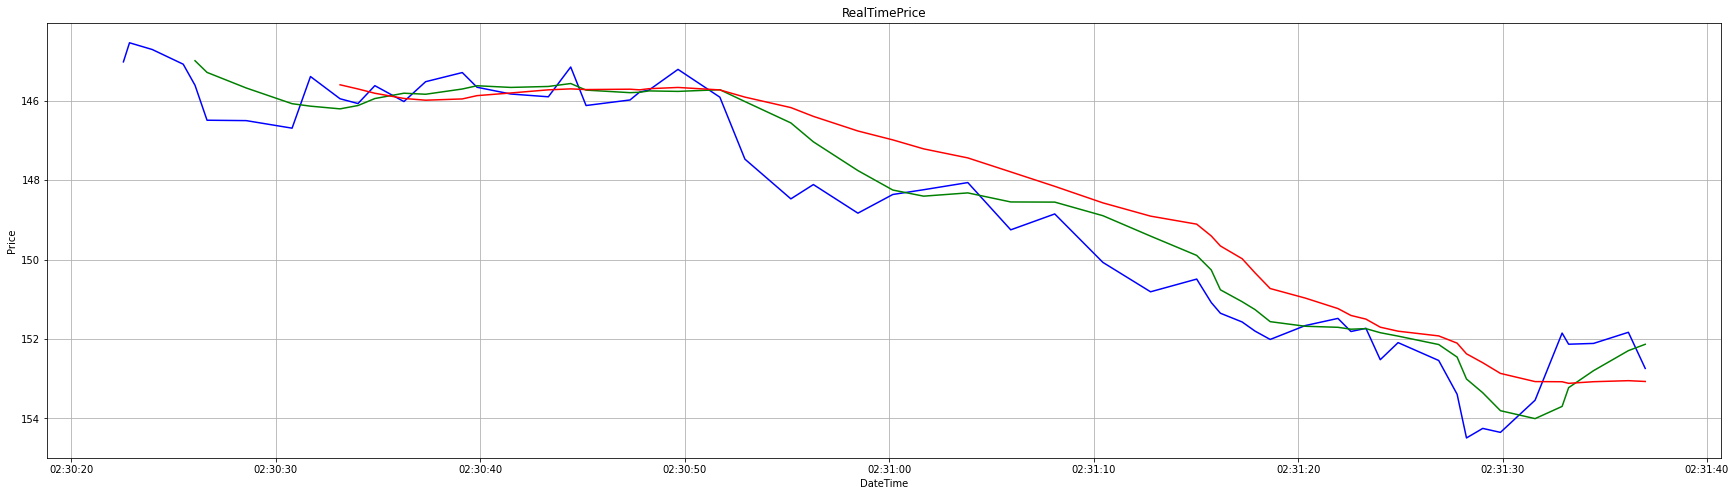

In [ ]:
%matplotlib inline

#Plot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# Plot
plt.ion()
fig = plt.figure(figsize=(30,8))

ip = InstrumentPrice()

df = pd.DataFrame()

c1,c2,c3 = "blue","green","red"     # 各プロットの色
l1,l2,l3 = "SYMBOL","SMA1","SMA1"   # 各ラベル

while True:
  msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
  time.sleep(random.random() * 2)
  t = datetime.datetime.now()
  sym, price = msg.split()
  df = df.append(pd.DataFrame({sym: float(price)}, index=[t]))
  df['SMA1'] = df[sym].rolling(5).mean()
  df['SMA2'] = df[sym].rolling(10).mean()

  # Plot
  clear_output(wait = True)
  plt.ylim(max(df[sym]) + 0.5, min(df[sym]) - 0.5 )   # y軸範囲
  plt.plot(df.index, df[sym], color=c1, label=l1)
  plt.plot(df.index, df['SMA1'], color=c2, label=l2)
  plt.plot(df.index, df['SMA2'], color=c3, label=l3)
  plt.title("RealTimePrice")  # グラフタイトル
  plt.xlabel("DateTime")     # x軸ラベル
  plt.ylabel("Price")     # y軸ラベル
  plt.grid()
  display(fig)
  plt.cla() # 現在のグラフを消去する

### 3つのリアルタイムストリームのサブプロット

#### ploty での3つのリアルタイムストリームのグラフのリアルタイム更新 ソケットクライアント

In [ ]:
import zmq
import datetime
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

symbol = 'SYMBOL'

f = make_subplots(rows=3, cols=1, shared_xaxes=True, row_heights=[0.7, 0.15, 0.15])
f.append_trace(go.Scatter(name=symbol),row=1,col=1)
f.append_trace(go.Scatter(name='SMA1',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'x'}),row=1,col=1)
f.append_trace(go.Scatter(name='SMA2',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'square'}),row=1,col=1)
f.append_trace(go.Scatter(name='RETURN',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-up'}),row=2,col=1)
f.append_trace(go.Scatter(name='MOMENTUM',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-down'}),row=3,col=1)

fig = go.FigureWidget(f)
fig

context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect('tcp://0.0.0.0:5555')
socket.setsockopt_string(zmq.SUBSCRIBE, 'SYMBOL')

df = pd.DataFrame()

for _ in range(75):
  msg = socket.recv_string()
  t = datetime.datetime.now()
  sym, price = msg.split()
  df = df.append(pd.DataFrame({sym: float(price)}, index=[t]))
  df['SMA1'] = df[sym].rolling(5).mean()
  df['SMA2'] = df[sym].rolling(10).mean()
  df['RET'] = np.log(df[sym]/df[sym].shift(1))
  df['MOM'] = df['RET'].rolling(10).mean()
  fig.data[0].x = df.index
  fig.data[1].x = df.index
  fig.data[2].x = df.index
  fig.data[3].x = df.index
  fig.data[4].x = df.index
  fig.data[0].y = df[sym]
  fig.data[1].y = df['SMA1']
  fig.data[2].y = df['SMA2']
  fig.data[3].y = df['RET']
  fig.data[4].y = df['MOM']
  fig.update_layout(height=800)

#### ploty での3つのストリームをサブプロットしたグラフのリアルタイム更新 動作確認

jypyternotebook　で部分更新がうまくいかずカクカクする

In [ ]:
import datetime
import time
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
plotly.__version__
from plotly.subplots import make_subplots

symbol = 'SYMBOL'

f = make_subplots(rows=3, cols=1, shared_xaxes=True, row_heights=[0.7, 0.15, 0.15])
f.append_trace(go.Scatter(name=symbol),row=1,col=1)
f.append_trace(go.Scatter(name='SMA1',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'x'}),row=1,col=1)
f.append_trace(go.Scatter(name='SMA2',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'square'}),row=1,col=1)
f.append_trace(go.Scatter(name='RETURN',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-up'}),row=2,col=1)
f.append_trace(go.Scatter(name='MOMENTUM',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-down'}),row=3,col=1)

fig = go.FigureWidget(f)
fig

df = pd.DataFrame()

ip = InstrumentPrice()

while True:
  msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
  time.sleep(random.random() * 2)
  t = datetime.datetime.now()
  sym, price = msg.split()
  df = df.append(pd.DataFrame({sym: float(price)}, index=[t]))
  df['SMA1'] = df[sym].rolling(5).mean()
  df['SMA2'] = df[sym].rolling(10).mean()
  df['RET'] = np.log(df[sym]/df[sym].shift(1))
  df['MOM'] = df['RET'].rolling(10).mean()
  #juptyer notebook の場合に必要
  clear_output(wait = True)
  fig.data[0].x = df.index
  fig.data[1].x = df.index
  fig.data[2].x = df.index
  fig.data[3].x = df.index
  fig.data[4].x = df.index
  fig.data[0].y = df[sym]
  fig.data[1].y = df['SMA1']
  fig.data[2].y = df['SMA2']
  fig.data[3].y = df['RET']
  fig.data[4].y = df['MOM']
  fig.update_layout(height=800)
  #juptyer notebook の場合に必要
  fig.show()

### 3つのリアルタイムストリームとシグナルをプロットする
3つのグラフをプロットする
* レート、SMA１、SMA２のグラフ
* 対数リターンのグラフ
* モメンタムのグラフ
---
3つのシグナルをプロットする
* ゴールデンクロス
* モメンタム
* 平均回帰



#### ランダムでレートを生成するクラス

In [ ]:
class InstrumentPrice(object):
    def __init__(self):
        self.symbol = 'SYMBOL'
        self.t = time.time() # 生成日時
        self.value = 145. # ブラウン運動で価格を生成するための基準価格
        self.sigma = 0.4 # ボラティリティ
        self.r = 0.01    # 短期金利 

    def simulate_value(self):
        ''' Generates a new, random stock price.
        '''
        t = time.time() # 
        dt = (t - self.t) / (252 * 8 * 60 * 60) # 現在時刻　と 前回の出力時間の差を 1年の取引営業日時間を秒　割った値
        dt *= 500 # Δtの値をパタメータにより調整している 
        self.t = t
        self.value *= math.exp((self.r - 0.5 * self.sigma ** 2) * dt +
                               self.sigma * math.sqrt(dt) * random.gauss(0, 1)) # 価格を計算して算出する
        return self.value

#### 取得したレートをデータフレームに保存し、テクニカル計算と、シグナル生成を行うクラス

In [ ]:
class InstrumenChart(object):
  def __init__(self):
    self.symbol = 'SYMBOL'

    # SMAゴールデンクロス
    self.sma1 = 12  
    self.sma2 = 25 

    # モメンタムパラメータ
    self.momentum = 3

    # 平均回帰パラメータ
    self.sma = 10 
    self.threshold = 2
    
    # シグナル制御
    self.smaposition = 0
    self.momposition = 0
    self.regposition = 0
    # データ
    self.value = pd.DataFrame()

  def update_symbol(self, symbol):
    self.symbol = symbol # 

  def update_sma_params(self, sma1,sma2):
    self.sma1 = sma1 # 
    self.sma2 = sma2 # 

  def update_momentum_params(self, momentum):
    self.momentum = momentum # 

  def update_regression_params(self, sma, threshold):
    self.sma = sma
    self.threshold = threshold

  def check_sma_signal(self) :
  
    result = 0

    if len(self.value) > self.sma2 + 1:
      if self.value['SMA1'].iloc[-2] > self.value['SMA2'].iloc[-2] :
        if self.smaposition in [0, -1]:
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Long market smaposition.\n')
          # take some action (e.g. place buy order)
          self.smaposition = 1
          result = self.smaposition

      elif self.value['SMA1'].iloc[-2] < self.value['SMA2'].iloc[-2] :
        if self.smaposition in [0, 1]:
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Short market smaposition.\n')
          # take some action (e.g. place sell order)
          self.smaposition = -1
          result = self.smaposition

    return result

  def check_momentum_signal(self) :
    
    result =0

    if len(self.value) > self.momentum + 1:
      if self.value['MOM'].iloc[-2] == 1.0:
        if self.momposition in [0, -1]:
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Long market momposition.\n')
          # take some action (e.g. place buy order)
          self.mompositio = 1
          result = self.mompositio

      elif self.value['MOM'].iloc[-2] == -1.0:
        if self.mompositio in [0, 1]:
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Short market momposition.\n')
          # take some action (e.g. place sell order)
          self.mompositio = -1
          result = self.mompositio

      return result

  def check_regression_signal(self) :
    
    result = 0

    if len(self.value) > self.sma + 1:
      self.value['sma'] = self.value[self.symbol].rolling(self.sma).mean()
      if self.regposition == 0:
        if (self.value[self.symbol].iloc[-2] < self.value['sma'].iloc[-2] - self.threshold):
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Long market regposition.\n')
          # take some action (e.g. place buy order)
          self.regposition = 1
          result = self.regposition

        elif (self.value[self.symbol].iloc[-2] > self.value['sma'].iloc[-2] + self.threshold):
          print('\n' + '=' * 51)
          print('NEW SIGNAL | {}'.format(datetime.datetime.now()))
          print('Short market regposition.\n')
          self.regposition = -1
          result = self.regposition

      elif self.regposition == 1:
        if self.value[self.symbol].iloc[-2] >= self.value['sma'].iloc[-2]:
          self.regposition = 0
          result = self.regposition

      elif self.regposition == -1:
        if self.value[self.symbol].iloc[-2] <= self.value['sma'].iloc[-2]:
          self.regposition = 0
          result = self.regposition

    return result

  def append_data(self,sym,price):
    t = datetime.datetime.now()
    self.value = self.value.append(pd.DataFrame({sym: float(price)}, index=[t]))
    self.value['SMA1'] = self.value[self.symbol].rolling(self.sma1).mean()
    self.value['SMA2'] = self.value[self.symbol].rolling(self.sma2).mean()
    self.value['RET'] = np.log(self.value[self.symbol]/self.value[sym].shift(1))
    self.value['MOM'] = self.value['RET'].rolling(self.momentum).mean()
    self.value['SMA'] = self.value[self.symbol].rolling(self.sma).mean()

    if len(self.value) == 1:
      self.value['SMA-SIG'] = np.nan
      self.value['MOM-SIG'] = np.nan
      self.value['REG-SIG'] = np.nan

    if self.check_sma_signal() != 0:
      self.value['SMA-SIG'].iloc[-1] = float(price)
    else:
      self.value['SMA-SIG'].iloc[-1] = np.nan

    if self.check_momentum_signal() != 0:
      self.value['MOM-SIG'].iloc[-1] = float(price)
    else:
      self.value['MOM-SIG'].iloc[-1] = np.nan
    
    if self.check_regression_signal() != 0:
      self.value['REG-SIG'].iloc[-1]  = float(price)
    else:
      self.value['REG-SIG'].iloc[-1]  = np.nan
      
    return self.value


#### ランダムに生成されたレートを受け取りテクニカルを計算して、リアルタイムでチャートを表示する処理

In [ ]:
import datetime
import time
import random
import math
import pandas as pd

from IPython.display import clear_output
import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
plotly.__version__
from plotly.subplots import make_subplots

# -------------------------
symbol = 'SYMBOL'

f = make_subplots(rows=3, cols=1, shared_xaxes=True, row_heights=[0.7, 0.15, 0.15])
f.append_trace(go.Scatter(name=symbol),row=1,col=1)

f.append_trace(go.Scatter(name='SMA1',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'x'}),row=1,col=1)
f.append_trace(go.Scatter(name='SMA2',line=dict(width=1,dash='dash'),mode='lines+markers',marker={'symbol':'square'}),row=1,col=1)
f.append_trace(go.Scatter(name='SMA-SIG',line=dict(width=1),mode='markers',marker={'symbol':'star'}),row=1,col=1)
f.append_trace(go.Scatter(name='MOM-SIG',line=dict(width=1),mode='markers',marker={'symbol':'cross'}),row=1,col=1)
f.append_trace(go.Scatter(name='REG-SIG',line=dict(width=1),mode='markers',marker={'symbol':'hexagon'}),row=1,col=1)

f.append_trace(go.Scatter(name='RETURN',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-up'}),row=2,col=1)
f.append_trace(go.Scatter(name='MOMENTUM',line=dict(width=1),mode='lines+markers',marker={'symbol':'triangle-down'}),row=3,col=1)

fig = go.FigureWidget(f)
fig

df = pd.DataFrame()
ip = InstrumentPrice()
ic = InstrumenChart()

while True:
  msg = '{} {:.2f}'.format(ip.symbol, ip.simulate_value())
  time.sleep(random.random() * 2)

  sym, price = msg.split()
  df = ic.append_data(sym,price)
  #juptyer notebook の場合に必要
  clear_output(wait = True)
  fig.data[0].x = df.index
  fig.data[1].x = df.index
  fig.data[2].x = df.index
  fig.data[3].x = df.index
  fig.data[4].x = df.index
  fig.data[5].x = df.index
  fig.data[6].x = df.index
  fig.data[7].x = df.index
  fig.data[0].y = df[symbol]
  fig.data[1].y = df['SMA1']
  fig.data[2].y = df['SMA2']
  fig.data[3].y = df['SMA-SIG']
  fig.data[4].y = df['MOM-SIG']
  fig.data[5].y = df['REG-SIG']
  fig.data[6].y = df['RET']
  fig.data[7].y = df['MOM']
  fig.update_layout(height=800)
  #juptyer notebook の場合に必要
  fig.show()

# Oanda APIでのFXトレード
--- 
2022/11

実際のマーケットの情報を取得して、自動売買を行うためのシステムを開発します

基本的な機能の実装
* 口座情報の取得
* ストリーミングデータの取得
* ヒストリカルデータの取得
* スポット売買
* 指値


今まで作成してきたテクニカルでのシグナル生成の実像 2022/12
* SMA
* モメンタム
* 平均回帰

ディスカッション 2023/01

---

そのほかの実装 2023/02
* 複数のシグナルの組み合わせ
* 機械学習のモデルを利用した自動取引
* ニュースやほかの金利、インデックスなど他のパラメータや要素を取り入れた自動取引


## 基本的な機能の実装

### 口座情報の取得

In [ ]:
summary = api.get_account_summary()

print("balance:" + json.dumps(summary['balance'], indent=2))

### ストリーミングデータの取得

In [ ]:

instrument = 'EUR_USD'

api.stream_data(instrument, stop=10)